In [1]:
import tensorflow as tf

In [2]:
# gpu_devices = tf.config.experimental.list_physical_devices("GPU")
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [2]:
import indl
from pathlib import Path
import sys
import numpy as np
from numpy import linalg as LA
import random
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import IncrementalPCA
from scipy import signal
from scipy import stats
from sklearn.model_selection import train_test_split
from indl.fileio import from_neuropype_h5
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.decomposition import FactorAnalysis
from itertools import cycle

import os

if Path.cwd().stem == 'Analysis':
    os.chdir(Path.cwd().parent.parent)

from misc.misc import sess_infos, load_macaque_pfc, dec_from_enc    
    
data_path = Path.cwd() / 'StudyLocationRule'/ 'Data' / 'Preprocessed'
if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")
    

load_kwargs = {
    'valid_outcomes': (0, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
load_kwargs_ul = {
    'valid_outcomes': (0, 9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, -1),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

load_kwargs_error = {
    'valid_outcomes': (9,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

load_kwargs_all = {
    'valid_outcomes': (0,9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

model_kwargs = dict(
    filt=8,
    kernLength=20,
    ds_rate=5,
    n_rnn=32,
    n_rnn2=0,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=32
)
model_kwargs1 = dict(
    filt=16,
    kernLength=30,
#     ds_rate=5,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)
model_kwargs2 = dict(
    filt=32,
    kernLength=30,
    ds_rate=5,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)

N_SPLITS = 10
BATCH_SIZE = 16
EPOCHS = 150
EPOCHS2 = 100
LABEL_SMOOTHING = 0.2

from indl.model import parts
from indl.model.helper import check_inputs
from indl.regularizers import KernelLengthRegularizer

def make_model(
    _input,
    num_classes,
    filt=32,
    kernLength=16,
    n_rnn=32,
    n_rnn2=0,
    dropoutRate=0.1,
    activation='tanh',
    l1_reg=0.010, l2_reg=0.010,
    norm_rate=0.25,
    latent_dim=32,
    return_model=True
):
    
    inputs = tf.keras.layers.Input(shape=_input.shape[1:])
    
#     if _input.shape[2] < 10:
#         kernLength = 4
#         filt = 4
#         ds_rate = 4
#     elif _input.shape[2] < 20:
#         kernLength = 8
#         ds_rate = 8
#     elif _input.shape[2] < 30:
#         kernLength = 16
    
#     input_shape = list(_input.shape)
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    # input_shape[2] = -1  # Comment out during debug
    # _y = layers.Reshape(input_shape[1:])(_input)  # Note that Reshape ignores the batch dimension.

    # RNN
#     if len(input_shape) < 4:
#         input_shape = input_shape + [1]
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
#     _y = tf.keras.layers.Reshape(input_shape[1:])(inputs)
    _y = tf.keras.layers.Conv1D(filt, kernLength, strides=1, padding='valid', dilation_rate=1, groups=1,
                                activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                                bias_initializer='zeros', kernel_regularizer=None,
                                bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
                                bias_constraint=None)(inputs)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    _y = tf.keras.layers.LSTM(n_rnn,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=n_rnn2 > 0,
                              stateful=False,
                              name='rnn1')(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    
    if n_rnn2 > 0:
        
        _y = tf.keras.layers.LSTM(n_rnn2,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=False,
                              stateful=False,
                              name='rnn2')(_y)
        _y = tf.keras.layers.Activation(activation)(_y)
        _y = tf.keras.layers.BatchNormalization()(_y)
        _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    # Dense
    _y = tf.keras.layers.Dense(latent_dim, activation=activation)(_y)
#     _y = parts.Bottleneck(_y, latent_dim=latent_dim, activation=activation)
    
    # Classify
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(_y)
#     outputs = parts.Classify(_y, n_classes=num_classes, norm_rate=norm_rate)
    

    if return_model is False:
        return outputs
    else:
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)


def kfold_pred(sess_id,X_rates,Y_class,name, verbose=1):
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    split_ix = 0
    histories = []
    per_fold_eval = []
    per_fold_true = []

    for trn, vld in splitter.split(X_rates, Y_class):
        print(f"\tSplit {split_ix + 1} of {N_SPLITS}")
        _y = tf.keras.utils.to_categorical(Y_class, num_classes=np.max(Y_class)+1)
        
        ds_train = tf.data.Dataset.from_tensor_slices((X_rates[trn], _y[trn]))
        ds_valid = tf.data.Dataset.from_tensor_slices((X_rates[vld], _y[vld]))

        # cast data types to GPU-friendly types.
        ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

        # TODO: augmentations (random slicing?)

        ds_train = ds_train.shuffle(len(trn) + 1)
        ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
        ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

        tf.keras.backend.clear_session()
        
#         randseed = 12345
#         random.seed(randseed)
#         np.random.seed(randseed)
#         tf.random.set_seed(randseed)
        
        model = make_model(X_rates, _y.shape[-1], **model_kwargs1)
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
        
        best_model_path = f'{name}_{sess_id}_split{split_ix}.h5'
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=best_model_path,
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                save_best_only=True,
                monitor='val_accuracy',
                verbose=verbose)
        ]

        hist = model.fit(x=ds_train, epochs=EPOCHS,
                         verbose=verbose,
                         validation_data=ds_valid,
                         callbacks=callbacks)
        # tf.keras.models.save_model(model, 'model.h5')
        histories.append(hist.history)
        
        model = tf.keras.models.load_model(best_model_path)
        per_fold_eval.append(model(X_rates[vld]).numpy())
        per_fold_true.append(Y_class[vld])
        
        split_ix += 1
        
    # Combine histories into one dictionary.
    history = {}
    for h in histories:
        for k,v in h.items():
            if k not in history:
                history[k] = v
            else:
                history[k].append(np.nan)
                history[k].extend(v)
                
    pred_y = np.concatenate([np.argmax(_, axis=1) for _ in per_fold_eval])
    true_y = np.concatenate(per_fold_true).flatten()
    accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"Accuracy: {accuracy}%\n\n")
    
    return history, accuracy, pred_y, true_y

Data directory found. Skipping download.


In [3]:
sess_infos.append ({'name': 'Marty',
                 'bank': 'A',
                 'name_short': 'm',
                 'date': '',
                 'exp_code': 'sra3_1_m_074_00+01',
                 'nsx': ''})

In [4]:
def load_session(s_idx, t_start=-np.inf, t_end=np.inf):
    if s_idx == 8:
        chunk = 2
    else:
        chunk = 1
    sess_info = sess_infos[s_idx]
    sess_id = sess_info['exp_code']
    sess_id = sess_id.replace("+", "") + "_segmented.h5"
    segmented_path = data_path / sess_id
    segmented_data = from_neuropype_h5(segmented_path)
    outcome = np.array(segmented_data[chunk][1]['axes'][0]['data']['OutcomeCode'])
    flag = np.argwhere(outcome>-1).flatten()
    outcome = outcome[flag]
    Y = np.array(segmented_data[chunk][1]['axes'][0]['data']['TargetClass']).flatten()[flag]
    Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
    X_rates = segmented_data[chunk][1]['data'][flag]
    X_rates = np.nan_to_num(X_rates)
#     X_rates = np.transpose(X_rates, (0, 2, 1))
    block = np.array(segmented_data[chunk][1]['axes'][0]['data']['Block']).flatten()[flag]
    b=np.diff(block, axis=0)
    border=np.array(np.where(b>0)).flatten()
    to_keep = [0]
    for i in range(len(border) - 1):
        if (border[i + 1] - border[i]) > 30 and (len(outcome)-border[i+1]) > 30:
            to_keep.append(i + 1)
    border = border[to_keep]
    color = np.array(segmented_data[chunk][1]['axes'][0]['data']['CueColour']).flatten()[flag]
    target = np.array(segmented_data[chunk][1]['axes'][0]['data']['TargetRule']).flatten()[flag]
    classes = np.array(segmented_data[chunk][1]['axes'][0]['data']['TargetClass']).flatten()[flag]
    times = np.array(segmented_data[chunk][1]['axes'][1]['times']).flatten()
    idx_e = np.argwhere(times < t_end).flatten()[-1]
    idx_s = np.argwhere(times > t_start).flatten()[0]
    rule = np.zeros(np.size(X_rates,0))
    for i in range(len(rule)):
        if (target[i]=='UU'):
            if (color[i] == 'r'):
                rule[i]=0
            elif(color[i] == 'g'):
                rule[i]=1
            else:
                rule[i]=2
        elif (target[i]=='UR'):
            if (color[i] == 'r'):
                rule[i]=3
            elif(color[i] == 'g'):
                rule[i]=4
            else:
                rule[i]=5
        elif (target[i]=='RR'):
            if (color[i] == 'r'):
                rule[i]=6
            elif(color[i] == 'g'):
                rule[i]=7
            else:
                rule[i]=8
        elif (target[i]=='DR'):
            if (color[i] == 'r'):
                rule[i]=9
            elif(color[i] == 'g'):
                rule[i]=10
            else:
                rule[i]=11
        elif (target[i]=='DD'):
            if (color[i] == 'r'):
                rule[i]=12
            elif(color[i] == 'g'):
                rule[i]=13
            else:
                rule[i]=14
        elif (target[i]=='DL'):
            if (color[i] == 'r'):
                rule[i]=15
            elif(color[i] == 'g'):
                rule[i]=16
            else:
                rule[i]=17
        elif (target[i]=='LL'):
            if (color[i] == 'r'):
                rule[i]=18
            elif(color[i] == 'g'):
                rule[i]=19
            else:
                rule[i]=20
        elif (target[i]=='UL'):
            if (color[i] == 'r'):
                rule[i]=21
            elif(color[i] == 'g'):
                rule[i]=22
            else:
                rule[i]=23
    rule = rule.astype(int)
#     tmp = rule
#     _yu = np.unique(rule)
#     for i in range(len(tmp)):
#         rule[i] = np.where(_yu == tmp[i])[0][0]
    
    m_performance = np.zeros(len(outcome))
    cor = 0
    b=0
    tot = 25
    for i in range(tot):
        if outcome[i]==0:
            cor += 1

    m_performance[:tot] = 100 * (cor / tot)
    # for i in range(tot, len(outcome)):
    i = tot
    while i<len(outcome):
        if i == border[b]:
            cor = 0
            for j in range(tot):
                if outcome[i+j]==0:
                    cor += 1
            m_performance[i:i+tot] = 100 * (cor / tot)
            i += tot
            b = (b+1)%len(border)
        elif outcome[i] == outcome[i-tot]:
            m_performance[i] = m_performance[i-1]
            i += 1
        elif outcome[i]==0:
            cor += 1
            m_performance[i] = 100 * (cor / tot)
            i += 1
        else:
            cor -= 1
            m_performance[i] = 100 * (cor / tot)
            i +=1

    for i in range(len(m_performance)):
        if m_performance[i]<0:
            m_performance[i] = 0
    learned = np.argwhere(m_performance>75).flatten()
    unlearned = np.argwhere(m_performance<65).flatten()
    cor = np.array(np.where(outcome==0)).flatten()
    icor = np.array(np.where(outcome==9)).flatten()
    ic_l = []
    c_l = []
    ic_ul = []
    for c in cor:
        if c in learned:
            c_l.append(c)
    for ic in icor:
        if ic in unlearned:
            ic_ul.append(ic)
        else:
            ic_l.append(ic)
    X_rates = X_rates[:, idx_s:idx_e+1, :]
    
    return X_rates, Y, rule, learned, unlearned, c_l, ic_ul, ic_l, border

# Forgetting Effect

In [5]:
T_MAX = np.inf
T_MIN = 0.75
for s_idx in range(1,4):
    X_rates, Y, rule, learned, unlearned, c_l, ic_ul, ic_l, border = load_session(s_idx, t_start=T_MIN, t_end=T_MAX)
    X_learned = X_rates[learned]
    rule_learned = rule[learned]
    b = [0] + list(border) + [X_rates.shape[0] + 1]
    idx = list(learned[np.argwhere((learned > b[0]-1) & (learned < b[1])).flatten()])
    X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
    for i in range(len(idx)):
        X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_rates[idx[i]]).T

    pca1 = PCA(n_components=20)
    X1 = pca1.fit_transform(X)

    X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
    for i in range(len(idx)):
        X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

    pca2 = PCA(n_components=5)
    X2 = pca2.fit_transform(X)

    X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
    for i in range(len(idx)):
        X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()
    transformed = X
    for i in range(2, len(b)):
        idx2 = list(learned[np.argwhere((learned > b[i-1]-1) & (learned < b[i])).flatten()])
        X = np.zeros((len(idx2)*X_learned.shape[2], X_learned.shape[1]))
        for i in range(len(idx2)):
            X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_rates[idx2[i]]).T

        X1 = pca1.transform(X)

        X = np.zeros((len(idx2)*X1.shape[1], X_learned.shape[2]))
        for i in range(len(idx2)):
            X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

        X2 = pca2.transform(X)

        X = np.zeros((len(idx2), X1.shape[1] * X2.shape[1]))
        for i in range(len(idx2)):
            X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()
        transformed = np.concatenate((transformed, X), axis=0)

        idx = idx + idx2
        X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
        for i in range(len(idx)):
            X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_rates[idx[i]]).T

        pca1 = PCA(n_components=20)
        X1 = pca1.fit_transform(X)

        X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
        for i in range(len(idx)):
            X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

        pca2 = PCA(n_components=5)
        pca2.fit(X)
    rule_idx=[]
    if s_idx == 1:
        r = np.array([[2, 13],[23,9],[2,13],[4,17],[7,18],[7,18],[0,13],[23,10],[4,15],[3,17]]) # sess 1
        dist1= np.zeros((r.shape[0]*2,r.shape[0]*2,100,100))
    elif s_idx == 2:
        r = np.array([[2, 13],[8,18],[8,18],[6,19],[6,20],[4,15],[5,15],[4,17]]) # sess 2
        dist2= np.zeros((r.shape[0]*2,r.shape[0]*2,100,100))
    elif s_idx == 3:
        r = np.array([[21, 11],[3,16],[8,18],[6,19],[2,12],[3,16]]) # sess 3
        dist3= np.zeros((r.shape[0]*2,r.shape[0]*2,100,100))
    for j in range(0,len(b)-1):
        idx=[]
        idx2=[]
        for i in np.argwhere((learned > b[j]-1) & (learned < b[j+1])).flatten():
            if rule_learned[i]==r[j,0]:
                idx.append(i)
            elif rule_learned[i]==r[j,1]:
                idx2.append(i)
        rule_idx.append(np.array(idx))
        rule_idx.append(np.array(idx2))
    for i in range(r.shape[0]*2):
        X1 = transformed[rule_idx[i]]
        for j in range(r.shape[0]*2):
            X2 = transformed[rule_idx[j]]
            if s_idx == 1:
                dist1[i,j]= ((np.transpose(X1)@X1)/X1.shape[0])-((np.transpose(X2)@X2)/X2.shape[0])
            elif s_idx == 2:
                dist2[i,j]= ((np.transpose(X1)@X1)/X1.shape[0])-((np.transpose(X2)@X2)/X2.shape[0])
            elif s_idx == 3:
                dist3[i,j]= ((np.transpose(X1)@X1)/X1.shape[0])-((np.transpose(X2)@X2)/X2.shape[0])

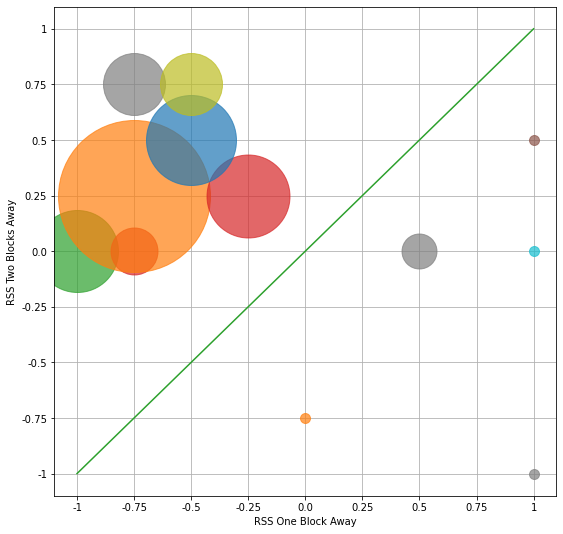

In [20]:
fem = np.zeros((9,9))
fem[0,8]=10
# fem[0,7]=34
fem[0,0]=120
fem[1,4]=10
# fem[1,2]=118
fem[4,8]=10
fem[4,6]=35
fem[4,4]=26
fem[4,1]=47
fem[4,0]=82
fem[5,3]=83
fem[5,1]=152
fem[6,8]=10
fem[6,6]=10
fem[6,2]=90
fem[7,1]=62
fem[7,2]=62
# fem[8,4]=10

fig = plt.figure(figsize=(9,9))
for i in range(9):
    for j in range(9):
        if (i!=j):
            plt.plot(j,i,marker='o', markersize=fem[i,j], alpha=0.7)
plt.plot([0,8],[0,8])
p = [0,1,2,3,4,5,6,7,8]
l = ["-1", "-0.75", "-0.5","-0.25","0.0", "0.25","0.5", "0.75", "1"]
plt.xticks(p,l)
plt.yticks(p,l)
plt.grid()
plt.ylabel("RSS Two Blocks Away")
plt.xlabel("RSS One Block Away")
plt.savefig("intereference.svg")

In [45]:
row = 5
col = 6
print(dist[row,col])

0.2573952351506914


In [23]:
a1 = dist1
a2 = dist2
a3 = dist3

In [56]:
dist1 = a1
dist2 = a2
dist3 = a3

In [14]:
# dist1=dist1/(LA.norm(dist1)**(1/m))
# dist2=dist2/(LA.norm(dist2)**(1/m))
# dist3=dist3/(LA.norm(dist3)**(1/m))
dist1=dist1/2
dist2=dist2/2
dist3=dist3/2

Text(0.5, 0, 'RSS One Block Away')

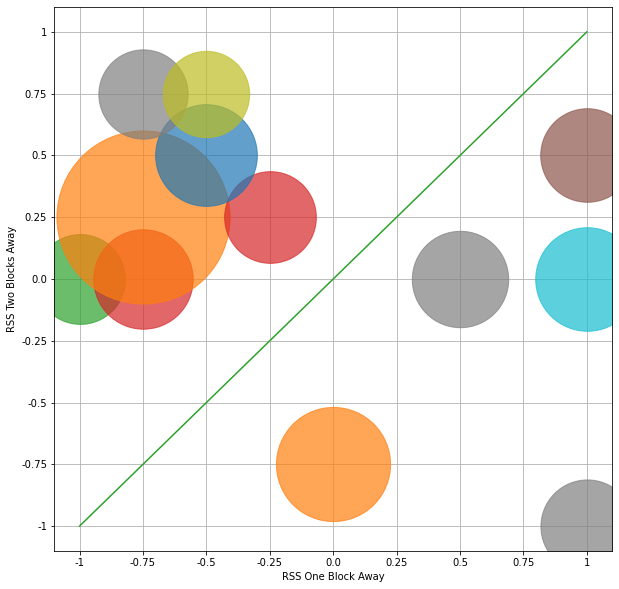

In [30]:
m=3
fem = np.zeros((9,9))
# fem[0,7]=34
fem[0,8]=LA.norm(dist2[5,8]+dist2[4,9]+dist2[6,8]+dist2[7,9])**(1/m)
fem[0,0]=LA.norm(dist2[3,6]+dist2[2,7]+dist2[5,6]+dist2[4,7])**(1/m)
fem[1,4]=LA.norm(dist1[13,16]+dist1[12,17]+dist1[15,16]+dist1[14,17])**(1/m)
# fem[1,2]=LA.norm(dist2[7,10]+dist2[6,11]+dist2[8,11]+dist2[9,10])**(1/m)
fem[4,8]=LA.norm(dist1[0,4]+dist1[1,5]+dist1[2,4]+dist1[3,5])**(1/m)
# fem[4,8]=LA.norm(dist2[0,4]+dist2[1,5]+dist2[2,4]+dist2[3,5])**(1/m)
# fem[4,8]=LA.norm(dist2[9,12]+dist2[8,13]+dist2[10,12]+dist2[11,13])**(1/m)
fem[7,1]=LA.norm(dist1[5,8]+dist1[4,9]+dist1[6,8]+dist1[7,9])**(1/m)
fem[4,4]=LA.norm(dist1[9,12]+dist1[8,13]+dist1[11,12]+dist1[10,13])**(1/m)
fem[4,1]=LA.norm(dist1[2,7]+dist1[3,6]+dist1[4,7]+dist1[5,6])**(1/m)
# fem[4,0]=LA.norm(dist3[2,6]+dist3[3,7]+dist3[5,6]+dist3[4,7])**(1/m)
fem[4,0]=LA.norm(dist1[15,18]+dist1[14,19]+dist1[17,18]+dist1[16,19])**(1/m)
fem[5,3]=LA.norm(dist3[4,8]+dist3[5,9]+dist3[6,9]+dist3[7,8])**(1/m)
fem[5,1]=LA.norm(dist2[3,6]+dist2[2,7]+dist2[5,6]+dist2[4,7])**(1/m)+30
fem[6,8]=LA.norm(dist1[6,10]+dist1[7,11]+dist1[8,10]+dist1[9,11])**(1/m)
fem[6,6]=LA.norm(dist1[11,14]+dist1[10,15]+dist1[12,14]+dist1[13,15])**(1/m)
fem[6,2]=LA.norm(dist3[4,8]+dist3[5,9]+dist3[6,9]+dist3[7,8])**(1/m)+10
fem[4,6]=LA.norm(dist2[10,14]+dist2[11,15]+dist2[13,14]+dist2[12,15])**(1/m)
fem[7,2]=LA.norm(dist3[1,4]+dist3[0,5]+dist3[3,4]+dist3[2,5])**(1/m)
# fem[8,4]=LA.norm(dist1[0,4]+dist1[1,5]+dist1[2,4]+dist1[3,5])**(1/m)

fig = plt.figure(figsize=(10,10))
for i in range(9):
    for j in range(9):
        if (i!=j):
            plt.plot(j,i,marker='o', markersize=fem[i,j], alpha=0.7)
plt.plot([0,8],[0,8])
p = [0,1,2,3,4,5,6,7,8]
l = ["-1", "-0.75", "-0.5","-0.25","0.0", "0.25","0.5", "0.75", "1"]
plt.xticks(p,l)
plt.yticks(p,l)
plt.grid()
plt.ylabel("RSS Two Blocks Away")
plt.xlabel("RSS One Block Away")

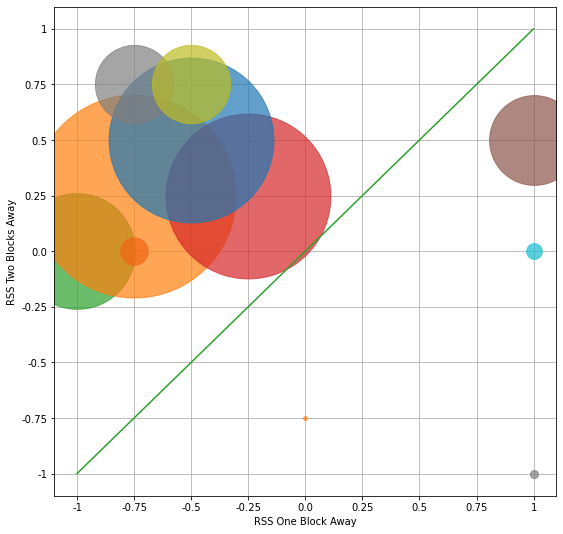

In [27]:
m=2
fem = np.zeros((9,9))
# fem[0,7]=34
fem[0,8]=np.sum(np.dot((dist2[5,8]+dist2[4,9]),(dist2[6,8]+dist2[7,9])))
fem[0,0]=np.sum(np.dot((dist2[3,6]+dist2[2,7]),(dist2[5,6]+dist2[4,7])))
fem[1,4]=np.sum(np.dot((dist1[13,16]+dist1[12,17]),(dist1[15,16]+dist1[14,17])))
# fem[1,2]=np.sum(np.dot((dist2[7,10]+dist2[6,11]),(dist2[8,11]+dist2[9,10])))
fem[4,8]=np.sum(np.dot((dist1[0,4]+dist1[1,5]),(dist1[2,4]+dist1[3,5])))
# fem[4,8]=np.sum(np.dot((dist2[0,4]+dist2[1,5]),(dist2[2,4]+dist2[3,5])))
# fem[4,8]=np.sum(np.dot((dist2[9,12]+dist2[8,13]),(dist2[10,12]+dist2[11,13])))
# fem[7,1]=np.sum(np.dot((dist1[5,8]+dist1[4,9]),(dist1[6,8]+dist1[7,9])))
fem[7,1]=np.sum(np.dot((dist3[1,4]+dist3[0,5]),(dist3[3,4]+dist3[2,5])))
fem[4,4]=np.sum(np.dot((dist1[9,12]+dist1[8,13]),(dist1[11,12]+dist1[10,13])))
fem[4,1]=np.sum(np.dot((dist1[2,7]+dist1[3,6]),(dist1[4,7]+dist1[5,6])))
# fem[4,0]=np.sum(np.multiply((dist3[2,6]+dist3[3,7]),(dist3[5,6]+dist3[4,7])))
fem[4,0]=np.sum(np.dot((dist1[15,18]+dist1[14,19]),(dist1[17,18]+dist1[16,19])))
fem[5,3]=np.sum(np.dot((dist3[4,8]+dist3[5,9]),(dist3[6,9]+dist3[7,8])))
fem[5,1]=np.sum(np.multiply((dist2[3,6]+dist2[2,7]),(dist2[5,6]+dist2[4,7])))/2.5
fem[6,8]=np.sum(np.dot((dist1[6,10]+dist1[7,11]),(dist1[8,10]+dist1[9,11])))
fem[6,6]=np.sum(np.dot((dist1[11,14]+dist1[10,15]),(dist1[12,14]+dist1[13,15])))
fem[6,2]=np.sum(np.dot((dist3[4,8]+dist3[5,9]),(dist3[6,9]+dist3[7,8])))
# fem[4,6]=np.sum(np.multiply((dist2[10,14]+dist2[11,15]),(dist2[13,14]+dist2[12,15])))+500000
fem[4,6]=np.sum(np.dot((dist1[5,8]+dist1[4,9]),(dist1[6,8]+dist1[7,9])))
fem[7,2]=np.sum(np.dot((dist3[1,4]+dist3[0,5]),(dist3[3,4]+dist3[2,5])))
# fem[8,4]=np.sum(np.multiply((dist1[0,4]+dist1[1,5]),(dist1[2,4]+dist1[3,5])))
fem = fem / 10000
fig = plt.figure(figsize=(9,9))
for i in range(9):
    for j in range(9):
        if (i!=j):
            plt.plot(j,i,marker='o', markersize=fem[i,j], alpha=0.7)
plt.plot([0,8],[0,8])
p = [0,1,2,3,4,5,6,7,8]
l = ["-1", "-0.75", "-0.5","-0.25","0.0", "0.25","0.5", "0.75", "1"]
plt.xticks(p,l)
plt.yticks(p,l)
plt.grid()
plt.ylabel("RSS Two Blocks Away")
plt.xlabel("RSS One Block Away")
plt.savefig("intereference_latent.svg")

# Latent Space Similar Rule Distance

In [23]:
s_idx = 1
T_MAX = 1.25
T_MIN = 0.25
X_rates, Y, rule, learned, unlearned, c_l, ic_ul, ic_l, border = load_session(s_idx, t_start=T_MIN, t_end=T_MAX)
X_learned = X_rates[learned]
rule_learned = rule[learned]
print(np.unique(rule_learned, return_counts=True))

(array([ 2,  3,  6,  8, 11, 12, 16, 18, 19, 21]), array([ 36, 130,  66,  38,  85,  36, 109,  47,  62,  65], dtype=int64))


In [31]:
X_rates.shape

(1270, 99, 36)

In [24]:
b = [0] + list(border) + [X_rates.shape[0]]
for i in range(1, len(b)):
    print(np.unique(rule[b[i-1]:b[i]], return_counts=True))

(array([11, 21]), array([127,  97], dtype=int64))
(array([ 3, 11, 16]), array([130,   1, 118], dtype=int64))
(array([ 8, 16, 18]), array([78,  1, 85], dtype=int64))
(array([ 6,  8, 12, 19]), array([178,   1,   1, 166], dtype=int64))
(array([ 2, 12, 19, 21]), array([100,  84,   1,   1], dtype=int64))
(array([ 3, 12, 16]), array([128,   1,  98], dtype=int64))


In [25]:
b = [0] + list(border) + [X_rates.shape[0] + 1]
idx = list(learned[np.argwhere((learned > b[0]-1) & (learned < b[1])).flatten()])
X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_rates[idx[i]]).T
    
pca1 = PCA(n_components=20)
X1 = pca1.fit_transform(X)

X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

pca2 = PCA(n_components=5)
X2 = pca2.fit_transform(X)

X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()
transformed = X
for i in range(2, len(b)):
    idx2 = list(learned[np.argwhere((learned > b[i-1]-1) & (learned < b[i])).flatten()])
    X = np.zeros((len(idx2)*X_learned.shape[2], X_learned.shape[1]))
    for i in range(len(idx2)):
        X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_rates[idx2[i]]).T

    X1 = pca1.transform(X)

    X = np.zeros((len(idx2)*X1.shape[1], X_learned.shape[2]))
    for i in range(len(idx2)):
        X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

    X2 = pca2.transform(X)

    X = np.zeros((len(idx2), X1.shape[1] * X2.shape[1]))
    for i in range(len(idx2)):
        X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()
    transformed = np.concatenate((transformed, X), axis=0)

    idx = idx + idx2
    X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
    for i in range(len(idx)):
        X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_rates[idx[i]]).T

    pca1 = PCA(n_components=20)
    X1 = pca1.fit_transform(X)

    X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
    for i in range(len(idx)):
        X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

    pca2 = PCA(n_components=5)
    pca2.fit(X)

In [15]:
transformed.shape

(757, 100)

In [16]:
X_learned.shape

(757, 99, 36)

In [26]:
rule_idx=[]
if s_idx == 1:
    r = np.array([[2, 13],[23,9],[2,13],[4,17],[7,18],[7,18],[0,13],[23,10],[4,15],[3,17]]) # sess 1
    dist1= np.zeros((r.shape[0]*2,r.shape[0]*2,100,100))
elif s_idx == 2:
    r = np.array([[2, 13],[8,18],[8,18],[6,19],[6,20],[4,15],[5,15],[4,17]]) # sess 2
    dist2= np.zeros((r.shape[0]*2,r.shape[0]*2,100,100))
elif s_idx == 3:
    r = np.array([[21, 11],[3,16],[8,18],[6,19],[2,12],[3,16]]) # sess 3
    dist3= np.zeros((r.shape[0]*2,r.shape[0]*2,100,100))
for j in range(0,len(b)-1):
    idx=[]
    idx2=[]
    for i in np.argwhere((learned > b[j]-1) & (learned < b[j+1])).flatten():
        if rule_learned[i]==r[j,0]:
            idx.append(i)
        elif rule_learned[i]==r[j,1]:
            idx2.append(i)
    rule_idx.append(np.array(idx))
    rule_idx.append(np.array(idx2))

In [21]:
r

array([[ 2, 13],
       [ 8, 18],
       [ 8, 18],
       [ 6, 19],
       [ 6, 20],
       [ 4, 15],
       [ 5, 15],
       [ 4, 17]])

In [27]:
dist = np.zeros((r.shape[0]*2,r.shape[0]*2))
# dist1= np.zeros((r.shape[0]*2,r.shape[0]*2,100,100))
# dist2= np.zeros((r.shape[0]*2,r.shape[0]*2,100,100))
# dist3= np.zeros((r.shape[0]*2,r.shape[0]*2,100,100))
for i in range(r.shape[0]*2):
    X1 = transformed[rule_idx[i]]
    for j in range(r.shape[0]*2):
        X2 = transformed[rule_idx[j]]
        dist[i,j] = np.sqrt(LA.norm(((np.transpose(X1)@X1)/X1.shape[0]-(np.transpose(X2)@X2)/X2.shape[0])))
        if s_idx == 1:
            dist1[i,j]= ((np.transpose(X1)@X1)/X1.shape[0])-((np.transpose(X2)@X2)/X2.shape[0])
        elif s_idx == 2:
            dist2[i,j]= ((np.transpose(X1)@X1)/X1.shape[0])-((np.transpose(X2)@X2)/X2.shape[0])
        elif s_idx == 3:
            dist3[i,j]= ((np.transpose(X1)@X1)/X1.shape[0])-((np.transpose(X2)@X2)/X2.shape[0])
        
# dist = dist / (2*np.max(dist))

In [36]:
row = 3
col = 5
print(dist[row,col])

0.2877826411470521


## RSS -0.5

### Sess 1 (13, 4)

In [36]:
idx = [0,  2,  4,  7,  8,  9, 10, 14, 16, 17, 19, 20, 23, 24, 26, 29, 32,
       39, 40, 41, 43]
X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
pca1 = PCA(n_components=20)
X1 = pca1.fit_transform(X)

X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

pca2 = PCA(n_components=5)
X2 = pca2.fit_transform(X)

X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [37]:
idx = [44,  49,  52,  54,  56,  58,  61,  62,  63,  65,  66,  67,  73,
        75,  76,  79,  81,  88,  91,  92,  93,  95,  98, 100, 102, 103,
       104, 111, 112, 113, 116, 118, 122, 124, 125, 128, 129, 132, 133,
       134, 135, 137, 139, 142, 147, 148, 153, 159, 160, 161, 162, 163,
       164, 166, 167, 171, 173]
Xrss1 = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    Xrss1[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
X1 = pca1.transform(Xrss1)

Xrss1 = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    Xrss1[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

X2 = pca2.transform(Xrss1)

Xrss1 = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    Xrss1[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [38]:
a = np.mean(X, axis=0)
b = np.mean(Xrss1, axis=0)
np.sqrt(np.sum((a-b)**2))

37.66382889489745

## Neutral Rules

### Sess 1 (0, 7)

In [106]:
idx = [324, 325, 327, 331, 333, 335, 336, 337, 338, 339, 344, 345, 346,
       348, 349, 352, 353, 354, 355, 356, 358, 362, 363, 365, 371, 373,
       377, 379, 380, 382, 384, 389, 393, 395, 396, 398, 399, 401, 404,
       405, 406, 409, 410, 413, 414, 416, 417, 418, 419, 421, 424, 427,
       428, 429, 430, 432, 436, 437, 438, 442, 443, 447, 448, 450, 453,
       454, 456, 457, 458, 459, 460, 462, 465, 466, 467, 480, 481, 482,
       483, 488, 489, 490, 491, 492, 493, 495, 496, 497, 498, 501, 502,
       503, 504, 505, 507, 511, 512, 513, 514, 515, 516, 519, 520, 521,
       524, 527, 530, 533, 534, 535, 537, 538]
X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
pca1 = PCA(n_components=20)
X1 = pca1.fit_transform(X)

X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

pca2 = PCA(n_components=5)
X2 = pca2.fit_transform(X)

X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [107]:
idx = [540, 542, 543, 545, 546, 547, 548, 550, 551, 552, 555, 557, 560,
       561, 564, 565, 566, 567, 570, 575, 576, 577, 578, 579, 580, 581,
       582, 584, 586, 588, 589]
Xrss1 = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    Xrss1[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
X1 = pca1.transform(Xrss1)

Xrss1 = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    Xrss1[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

X2 = pca2.transform(Xrss1)

Xrss1 = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    Xrss1[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [108]:
a = np.mean(X, axis=0)
b = np.mean(Xrss1, axis=0)
np.sqrt(np.sum((a-b)**2))

451.27087659074016

### Sess 2 (6, 13)

In [192]:
idx = [1,  3,  5,  6, 11, 12, 13, 15, 18, 21, 22, 25, 27, 28, 30, 31, 33,
       34, 35, 36, 37, 38, 42]
X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
pca1 = PCA(n_components=20)
X1 = pca1.fit_transform(X)

X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

pca2 = PCA(n_components=5)
X2 = pca2.fit_transform(X)

X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [193]:
idx = [174, 175, 180, 185, 186, 187, 190, 191, 193, 194, 195, 197, 201,
       202, 204, 205, 206, 208, 209, 211, 212, 213, 215, 219, 221, 223,
       225, 226, 227, 231, 232, 233, 234, 238, 239, 240, 241, 243, 244,
       245, 247, 248, 250, 252, 255, 256, 257]
Xrss1 = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    Xrss1[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
X1 = pca1.transform(Xrss1)

Xrss1 = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    Xrss1[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

X2 = pca2.transform(Xrss1)

Xrss1 = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    Xrss1[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [194]:
a = np.mean(X, axis=0)
b = np.mean(Xrss1, axis=0)
np.sqrt(np.sum((a-b)**2))

29.96691211792089

### Sess 3 (2, 6)

In [211]:
idx = [92,  95,  98, 100, 106, 108, 109, 111, 112, 115, 116, 117, 121,
       122, 127, 128, 133, 271, 277, 278, 279, 285]
X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
pca1 = PCA(n_components=20)
X1 = pca1.fit_transform(X)

X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

pca2 = PCA(n_components=5)
X2 = pca2.fit_transform(X)

X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [212]:
idx = [136, 139, 140, 143, 144, 146, 147, 149, 151, 152, 153, 157, 158,
       160, 163, 165, 166, 167, 168, 169, 170, 171, 172]
Xrss1 = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    Xrss1[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
X1 = pca1.transform(Xrss1)

Xrss1 = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    Xrss1[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

X2 = pca2.transform(Xrss1)

Xrss1 = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    Xrss1[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [213]:
a = np.mean(X, axis=0)
b = np.mean(Xrss1, axis=0)
np.sqrt(np.sum((a-b)**2))

28.74422672472099

### Sess 5 (16, 21)

In [78]:
idx = [2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 18, 19, 20, 21, 22,
       25, 27]
X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
pca1 = PCA(n_components=20)
X1 = pca1.fit_transform(X)

X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

pca2 = PCA(n_components=5)
X2 = pca2.fit_transform(X)

X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [79]:
idx = [28,  29,  30,  31,  32,  33,  34,  35, 126, 127, 128]
Xrss1 = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    Xrss1[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
X1 = pca1.transform(Xrss1)

Xrss1 = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    Xrss1[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

X2 = pca2.transform(Xrss1)

Xrss1 = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    Xrss1[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [80]:
a = np.mean(X, axis=0)
b = np.mean(Xrss1, axis=0)
np.sqrt(np.sum((a-b)**2))

12.638556640370076

## RSS 1

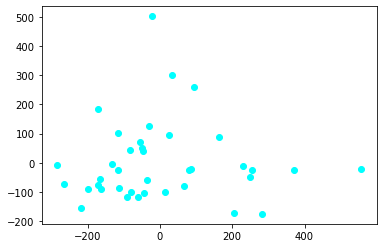

In [134]:
idx = [73,  75,  77,  81,  82,  84,  85,  87,  90,  92,  94,  96,  98,
       101, 102, 106, 107, 109, 110, 111, 112, 113, 114, 115, 118, 123,
       124, 126, 128, 129, 132, 133, 134, 135, 136, 137, 139, 143]
X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
pca1 = PCA(n_components=20)
X1 = pca1.fit_transform(X)

X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

pca2 = PCA(n_components=5)
X2 = pca2.fit_transform(X)

X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

pca3 = PCA(n_components=2)
X3 = pca3.fit_transform(X)

for i in range(len(idx)):
    plt.plot(X3[i,0],X3[i,1],marker='o',color='cyan')

In [135]:
idx = [594, 597, 598, 601, 602, 603, 605, 606, 607, 608, 611, 613, 614, 616,
       617, 618, 621, 623, 624, 625, 627, 628, 629, 630, 631, 632, 634,
       635, 637, 639, 640, 643, 648, 652, 653, 654, 655, 657, 661, 663,
       665, 667]
Xrss1 = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    Xrss1[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
X1 = pca1.transform(Xrss1)

Xrss1 = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    Xrss1[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

X2 = pca2.transform(Xrss1)

Xrss1 = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    Xrss1[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [35]:
np.mean(X, axis=0)

array([ 5.10737631e+02, -1.08001942e+01, -1.11049249e+01,  1.65357108e+01,
        6.42039973e+00, -4.78825513e+01,  2.29222626e+02,  1.25805301e+01,
        2.23340644e+01, -3.53254819e+01, -3.92809119e+01, -2.82958442e+01,
       -3.65827193e+01,  6.21749739e+01,  2.38388127e+01, -3.17136760e+01,
       -1.68907622e+01, -1.94394307e+01,  7.98027896e+00,  1.50094789e+01,
       -1.49206019e+01, -1.60248433e+01,  1.14949832e+01, -1.57523899e+01,
        1.47211768e+01, -2.33916402e+01, -6.84647666e+00,  1.33801480e+01,
       -1.41470436e+00, -5.85160816e-01, -2.35035275e+01, -1.80815817e+01,
       -7.91390805e+00, -5.58643844e+00,  1.64277524e+00, -1.99273365e+01,
       -9.88433841e-01, -4.56561254e+00, -1.41229188e+01,  4.06129884e+00,
       -2.47808603e+01, -1.31000047e+00,  1.89445031e+00, -1.83202213e+01,
       -9.00519569e+00, -3.33143385e+01, -1.19427934e+01,  1.49990282e-01,
        1.80398793e+00, -4.73124274e+00, -2.44491914e+01, -1.07250792e+01,
        6.73763167e-01, -

In [36]:
np.mean(Xrss1, axis=0)

array([ 5.06500599e+02,  1.03661385e+02,  8.56131686e+01, -3.63374212e+01,
        8.52864921e+01, -3.24664329e+01,  2.20573328e+02,  1.54511630e+01,
       -1.30574817e+01, -3.72338435e+00,  1.02319139e+01,  1.70581087e+01,
       -2.23521475e+01,  7.46969833e+00,  4.95314331e+00, -6.79089413e+00,
       -3.73490765e-01, -3.01645506e+00, -1.08344014e+01,  1.83816047e+00,
       -3.37552364e+01, -2.79972442e+01, -2.87487814e+00, -4.14724704e+00,
        5.78964120e+00,  1.36316646e+01,  1.06403553e+01,  1.59894996e+01,
       -3.37885453e+01, -9.39215977e+00, -4.19274417e+01, -4.42309399e+01,
       -1.62389258e+00,  4.28339903e-01,  4.56500910e+00,  1.88847106e-01,
       -4.74678847e+00, -6.04508716e+00, -2.19414760e+01, -9.12272806e+00,
       -2.11025968e+01, -1.28253618e+01, -1.00227814e+01, -2.11676768e+01,
       -1.56453225e+01, -3.43509608e+01, -4.81403942e+00,  1.08252945e+01,
        3.02035996e+00,  7.39604295e+00, -1.93965935e+01,  3.14469426e+00,
        1.20640788e+01, -

In [136]:
a = np.mean(X, axis=0)
b = np.mean(Xrss1, axis=0)
np.sqrt(np.sum((a-b)**2))

226.89693680751813

### sess 2, rule 2

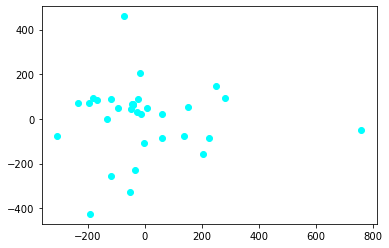

In [62]:
idx = [1,   3,   6,   7,   8,  11,  12,  15,  16,  19,  20,  21,  25,
        26,  29,  33,  36,  38,  42,  45,  46,  50,  51,  53,  54,  57,
        62,  63,  65,  70,  71,  72]
X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
pca1 = PCA(n_components=20)
X1 = pca1.fit_transform(X)

X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

pca2 = PCA(n_components=5)
X2 = pca2.fit_transform(X)

X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

pca3 = PCA(n_components=2)
X3 = pca3.fit_transform(X)

for i in range(len(idx)):
    plt.plot(X3[i,0],X3[i,1],marker='o',color='cyan')

In [63]:
idx = [148, 150, 152, 153, 157, 158, 159,
       160, 161, 162, 163, 164, 167, 168, 171, 172, 178, 179, 181, 182,
       184, 185, 187, 188, 189, 191, 193, 194, 196]
Xrss1 = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    Xrss1[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
X1 = pca1.transform(Xrss1)

Xrss1 = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    Xrss1[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

X2 = pca2.transform(Xrss1)

Xrss1 = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    Xrss1[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [64]:
np.mean(X, axis=0)

array([ 7.45246353e+02,  4.00103223e+01,  7.22388799e+00, -2.87455438e+01,
       -6.27248257e+00, -6.43641094e+01,  2.29642042e+02,  5.01250847e+00,
        3.56702712e+00, -8.70788775e+00, -3.42653181e+01, -2.93160503e+01,
       -1.32149448e+01,  7.01783599e+01, -3.27678341e+00, -3.60208566e+01,
       -3.90494480e+01, -3.58284353e+01, -3.25649240e+01, -1.52228692e+01,
       -4.50690296e+01, -6.10345347e+00, -3.85116343e+01, -3.28601327e+01,
       -1.82397774e+01, -3.30073145e+01, -2.01424611e+01, -2.63796318e+01,
        3.41778975e+00, -1.76582762e+01, -4.87536912e+01, -1.71633565e+01,
        1.53567216e+00, -1.26695038e+01,  8.81356060e-01, -3.72918610e+01,
       -9.38112408e+00,  1.81335821e+01,  8.16818700e+00,  1.42785960e+01,
       -3.38034926e+01, -2.45562014e+01,  8.62700776e+00, -2.16052506e+00,
        7.77561481e+00, -3.55062470e+01, -2.59571339e+00,  1.28355447e+01,
        2.46854787e+00,  7.25478171e-01, -3.77583032e+01, -8.16683671e+00,
        1.06286467e+01,  

In [65]:
np.mean(Xrss1, axis=0)

array([ 6.66773089e+02,  4.73997035e+01,  1.04692456e+01,  8.69337045e+01,
        1.48732465e+01, -5.02188741e+01,  2.06133472e+02,  1.70815686e+01,
        1.91218975e+01, -4.20027119e+00, -5.67780867e+01,  8.14288900e+00,
       -1.00656622e+01,  5.21929214e+01,  1.03263466e+01, -1.16043291e+00,
       -3.88523082e+01, -4.89018489e+01, -2.46628695e+01, -2.28714934e+01,
       -5.32071804e+01, -1.58671495e-01, -3.06567975e+01, -1.94939988e+01,
       -2.57825415e+01, -2.46486572e+01, -1.69730915e+01, -2.31114353e+01,
       -1.55603226e+00,  2.70651965e+00, -4.10281034e+01, -1.33754600e+01,
        2.48311509e+00, -5.80522788e+00,  1.00800586e+01, -2.44052540e+01,
       -1.19902626e+01,  5.93127124e+00,  1.39696315e+01,  2.29604093e+01,
       -4.91560240e+01, -1.81401613e+01,  4.95417365e+00, -8.50719271e+00,
       -1.11328215e+00, -3.31282149e+01, -8.14323890e+00,  5.16486650e+00,
        2.53765206e+00,  1.18845662e+01, -3.18352385e+01, -5.97003422e+00,
        5.35418160e+00,  

In [66]:
a = np.mean(X, axis=0)
b = np.mean(Xrss1, axis=0)
np.sqrt(np.sum((a-b)**2))

167.0822510667137

### sess 3, rule 16

In [234]:
idx = [90,  91,  93,  94,  96,  97,  99, 101, 102, 103, 104, 105, 107,
       110, 113, 114, 118, 119, 120, 123, 124, 125, 126, 129, 130, 131,
       132, 134, 135]
X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
pca1 = PCA(n_components=20)
X1 = pca1.fit_transform(X)

X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

pca2 = PCA(n_components=5)
X2 = pca2.fit_transform(X)

X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

pca3 = PCA(n_components=2)
X3 = pca3.fit_transform(X)

In [235]:
idx = [270, 272, 273, 274, 275, 276, 280, 281, 282, 283,
       284, 286, 287, 288, 289, 290]
Xrss1 = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    Xrss1[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
X1 = pca1.transform(Xrss1)

Xrss1 = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    Xrss1[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

X2 = pca2.transform(Xrss1)

Xrss1 = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    Xrss1[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [236]:
a = np.mean(X, axis=0)
b = np.mean(Xrss1, axis=0)
np.sqrt(np.sum((a-b)**2))

39.719698119907804

### sess 2, rule 13

In [79]:
idx = [0,   2,   4,   5,   9,  10,  13,  14,  17,  18,  22,  23,  24,
        27,  28,  30,  31,  32,  34,  35,  37,  39,  40,  41,  43,  44,
        47,  48,  49,  52,  55,  56,  58,  59,  60,  61,  64,  66,  67,
        68,  69]
X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
pca1 = PCA(n_components=20)
X1 = pca1.fit_transform(X)

X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

pca2 = PCA(n_components=5)
X2 = pca2.fit_transform(X)

X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [86]:
idx = [146, 147, 149, 151, 154, 155, 156, 165, 166, 169, 170,
       173, 174, 175, 176, 177, 180, 183, 186, 190, 192, 195, 197, 198]
Xrss1 = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    Xrss1[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
X1 = pca1.transform(Xrss1)

Xrss1 = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    Xrss1[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

X2 = pca2.transform(Xrss1)

Xrss1 = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    Xrss1[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [87]:
a = np.mean(X, axis=0)
b = np.mean(Xrss1, axis=0)
np.sqrt(np.sum((a-b)**2))

200.68173934132807

### sess 2, rule 17

In [90]:
idx = [201, 203, 204, 205, 208, 209, 210, 217, 222, 226, 227, 231, 232,
       236, 237, 240, 242, 243, 244, 245, 249, 250, 252, 254, 256, 258,
       259, 260, 261, 262, 265, 270, 271, 274, 275, 276, 285, 286, 287,
       290, 291, 292, 293, 296, 297, 298, 299, 301, 302, 305, 309, 310,
       311, 313, 315, 316, 320]
X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
pca1 = PCA(n_components=20)
X1 = pca1.fit_transform(X)

X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

pca2 = PCA(n_components=5)
X2 = pca2.fit_transform(X)

X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [91]:
idx = [714, 715, 716, 719, 720, 721, 723, 724,
       727, 728, 730, 731, 732, 734, 735, 737, 738, 739, 740, 742, 747,
       748, 750, 751, 755, 758, 761, 762, 764, 766, 767, 772, 777, 779]
Xrss1 = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    Xrss1[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
X1 = pca1.transform(Xrss1)

Xrss1 = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    Xrss1[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

X2 = pca2.transform(Xrss1)

Xrss1 = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    Xrss1[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [92]:
a = np.mean(X, axis=0)
b = np.mean(Xrss1, axis=0)
np.sqrt(np.sum((a-b)**2))

111.16683011548605

### sess 2, rule 23

In [95]:
idx = [73,  75,  77,  81,  82,  84,  85,  87,  90,  92,  94,  96,  98,
       101, 102, 106, 107, 109, 110, 111, 112, 113, 114, 115, 118, 123,
       124, 126, 128, 129, 132, 133, 134, 135, 136, 137, 139, 143]
X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
pca1 = PCA(n_components=20)
X1 = pca1.fit_transform(X)

X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

pca2 = PCA(n_components=5)
X2 = pca2.fit_transform(X)

X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [96]:
idx = [594, 597, 598, 601, 602, 603, 605, 606, 607, 608, 611, 613, 614, 616,
       617, 618, 621, 623, 624, 625, 627, 628, 629, 630, 631, 632, 634,
       635, 637, 639, 640, 643, 648, 652, 653, 654, 655, 657, 661, 663,
       665, 667]
Xrss1 = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    Xrss1[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
X1 = pca1.transform(Xrss1)

Xrss1 = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    Xrss1[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

X2 = pca2.transform(Xrss1)

Xrss1 = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    Xrss1[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [97]:
a = np.mean(X, axis=0)
b = np.mean(Xrss1, axis=0)
np.sqrt(np.sum((a-b)**2))

226.89503946631632

## RSS -1

In [161]:
idx = [540, 542, 543, 545, 546, 547, 548, 550, 551, 552, 555, 557, 560,
       561, 564, 565, 566, 567, 570, 575, 576, 577, 578, 579, 580, 581,
       582, 584, 586, 588, 589]
X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
pca1 = PCA(n_components=20)
X1 = pca1.fit_transform(X)

X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

pca2 = PCA(n_components=5)
X2 = pca2.fit_transform(X)

X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

pca3 = PCA(n_components=2)
X3 = pca3.fit_transform(X)


In [162]:
idx = [468, 469, 470, 471]
Xrss1 = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    Xrss1[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
X1 = pca1.transform(Xrss1)

Xrss1 = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    Xrss1[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

X2 = pca2.transform(Xrss1)

Xrss1 = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    Xrss1[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [163]:
a = np.mean(X, axis=0)
b = np.mean(Xrss1, axis=0)
np.sqrt(np.sum((a-b)**2))

412.0763018101089

### Sess 2, (5, 17)

In [177]:
idx = [318, 320, 324, 326, 330, 332, 334, 339, 340, 342, 350, 351, 352,
       356]
X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
pca1 = PCA(n_components=20)
X1 = pca1.fit_transform(X)

X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

pca2 = PCA(n_components=5)
X2 = pca2.fit_transform(X)

X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [178]:
idx = [360, 361, 362, 363, 367, 371, 372, 373, 376, 377, 378, 379, 380,
       382, 383, 385, 386, 387, 388, 389, 394, 395, 396, 397, 398]
Xrss1 = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    Xrss1[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
X1 = pca1.transform(Xrss1)

Xrss1 = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    Xrss1[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

X2 = pca2.transform(Xrss1)

Xrss1 = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    Xrss1[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [179]:
a = np.mean(X, axis=0)
b = np.mean(Xrss1, axis=0)
np.sqrt(np.sum((a-b)**2))

19.920964489044362

### Sess 3, (6, 18)

In [231]:
idx = [174, 176, 177, 179, 181, 182, 185, 186, 187, 188, 190, 192, 194,
       195, 197, 198, 199, 200, 203, 205, 207, 208, 209, 211, 212, 213,
       216, 217, 218, 221, 222, 223, 224, 225, 226, 231, 232, 234, 235,
       236, 237, 239, 240, 244, 245, 246, 247, 248]
X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
pca1 = PCA(n_components=20)
X1 = pca1.fit_transform(X)

X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

pca2 = PCA(n_components=5)
X2 = pca2.fit_transform(X)

X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [232]:
idx = [137, 138, 141, 142, 145, 148, 150, 154, 155, 156, 159, 161, 162,
       164, 173]
Xrss1 = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    Xrss1[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
X1 = pca1.transform(Xrss1)

Xrss1 = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    Xrss1[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

X2 = pca2.transform(Xrss1)

Xrss1 = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    Xrss1[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [233]:
a = np.mean(X, axis=0)
b = np.mean(Xrss1, axis=0)
np.sqrt(np.sum((a-b)**2))

20.972108780075548

### Sess 5, (6, 18)

In [268]:
idx = [36,  37,  38,  39,  45,  46,  50,  52,  54,  56,  58,  61,  63,
        65,  67,  69,  71,  75,  77,  78,  80,  82,  83,  84,  85,  88,
        89,  90,  91,  93,  95,  98,  99, 101, 102, 103, 104, 106, 107]
X = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    X[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
pca1 = PCA(n_components=20)
X1 = pca1.fit_transform(X)

X = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    X[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

pca2 = PCA(n_components=5)
X2 = pca2.fit_transform(X)

X = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    X[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [269]:
idx = [109, 113, 114, 115, 116, 119, 122, 123, 124]
Xrss1 = np.zeros((len(idx)*X_learned.shape[2], X_learned.shape[1]))
for i in range(len(idx)):
    Xrss1[i*X_learned.shape[2]: (i+1)*X_learned.shape[2], :] = np.squeeze(X_learned[idx[i]]).T
    
X1 = pca1.transform(Xrss1)

Xrss1 = np.zeros((len(idx)*X1.shape[1], X_learned.shape[2]))
for i in range(len(idx)):
    Xrss1[i*X1.shape[1]:(i+1)*X1.shape[1], :] = X1[i*X_learned.shape[2]:(i+1)*X_learned.shape[2], :].T

X2 = pca2.transform(Xrss1)

Xrss1 = np.zeros((len(idx), X1.shape[1] * X2.shape[1]))
for i in range(len(idx)):
    Xrss1[i, :] = X2[i*X1.shape[1]:(i+1)*X1.shape[1], :].flatten()

In [270]:
a = np.mean(X, axis=0)
b = np.mean(Xrss1, axis=0)
np.sqrt(np.sum((a-b)**2))

9.235245423632996

In [237]:
s_idx = 5
T_MAX = 1.45
T_MIN = 0
X_rates, Y, rule, learned, unlearned, c_l, ic_ul, ic_l = load_session(s_idx, t_start=T_MIN, t_end=T_MAX)
X_learned = X_rates[learned]
rule_learned = rule[learned]
print(np.unique(rule_learned))

[ 6  8 10 16 18 19 21 23]


In [215]:
np.argwhere(rule_learned==6).flatten()

array([174, 176, 177, 179, 181, 182, 185, 186, 187, 188, 190, 192, 194,
       195, 197, 198, 199, 200, 203, 205, 207, 208, 209, 211, 212, 213,
       216, 217, 218, 221, 222, 223, 224, 225, 226, 231, 232, 234, 235,
       236, 237, 239, 240, 244, 245, 246, 247, 248], dtype=int64)

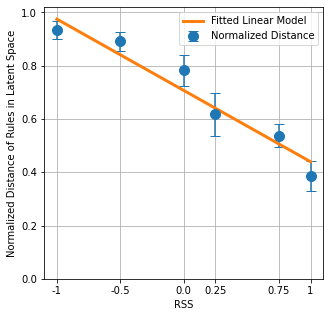

In [17]:
plt.figure(figsize=(5,5))
p = [-1, -0.5, 0.0, 0.25, 0.75, 1]
x = [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-.5,-.5,-.5,-.5,-.5,-.5,-.5,-.5,-.5,-.5,0,0,0,0,0,0,0,0,0,0,0.25,0.25,0.25,0.25,
     0.25,0.25,0.25,0.25,0.25,0.25,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,1,1,1,1,1,1,1,1,1,1]
y = [0.47060431,0.46919378,0.46608955,0.43311404,0.46608955,0.4935631,0.48819465,0.46025645,0.45148687,0.46919378,
    0.41660472,0.42554191,0.47060431,0.42554191,0.43206866,0.43341848,0.40057758,0.40932008,0.41660443,0.42488055,
    0.46919378,0.40932008,0.38087621,0.40057758,0.38526801,0.38122559,0.36266173,0.38533932,0.37608731,0.36438002,
    0.29072802,0.37608731,0.31394658,0.3387681,0.2948543,0.29786349,0.29796858,0.21262282,0.33028902,0.33241842,
    0.2953976,0.27435858,0.2664055,0.26552351,0.26267236,0.27692681,0.25010187,0.30305333,0.21967157,0.27326948,
    0.18671827,0.14783386,0.15601248,0.20842128,0.21722556,0.222167,0.22249631,0.15601248,0.20346332,0.20916751]
m, b = np.polyfit(x,np.dot(y,2), 1)
y2 = np.dot(m,x) + b
plt.errorbar(p, np.dot([0.466778608, 0.445516263, 0.391492963, 0.308554664, 0.268738061, 0.192951807],2), yerr=np.dot([0.016164735, 0.01783762, 0.02921676, 0.040594603, 0.021942751, 0.027806258],2), fmt='.', markersize='20', capsize=5, label="Normalized Distance")
plt.plot(x, y2, lw=3, color='tab:orange', label='Fitted Linear Model')
plt.ylim([0, 1.02])
l = ["-1", "-0.5", "0.0", "0.25", "0.75", "1"]
plt.xticks(p,l)
plt.ylabel("Normalized Distance of Rules in Latent Space")
plt.xlabel("RSS")
plt.grid()
plt.legend()
# handles, labels = plt.gca().get_legend_handles_labels()

# #specify order of items in legend
# order = [1,0]

# #add legend to plot
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.savefig("rule_latent_distance.svg")

In [40]:
print(m,b)

-0.26757323617647055 0.7069752250147059


In [20]:
import statsmodels.api as sm

x=np.array(x)
y=np.array(y)

mod = sm.OLS(y, x)
res = mod.fit()
print (res.conf_int(0.05))   # 95% confidence interval

[[-0.13479272 -0.0098283 ]]


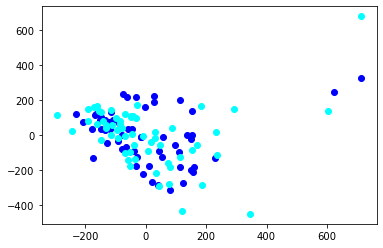

In [118]:
rl1 = 16
rl2 = 4
idx = [1148, 1150, 1152, 1154, 1155, 1156, 1157, 1158, 1160, 1168, 1169,
       1170, 1171, 1173, 1174, 1175, 1176, 1178, 1179, 1180, 1181, 1185,
       1187, 1188, 1191, 1193, 1195, 1197, 1198, 1199, 1200, 1202, 1203,
       1204, 1206, 1207, 1210, 1212, 1213, 1215, 1217, 1218, 1221, 1223,
       1226, 1227, 1230, 1232, 1236, 1237, 1238, 1239, 1242, 1246, 1248,
       1250, 1252, 1253, 1254]
x = X_rates[idx,:,:].reshape(len(idx),-1, order='F')
y = rule[idx]
pca = PCA(n_components=5)
ls = pca.fit_transform(x)
for i in range(len(ls)):
    if y[i] == rl1:
        c = 'red'
    else:
        c='blue'
    plt.plot(ls[i,0],ls[i,1],marker='o',color=c)
idx = [1256, 1259, 1260, 1264, 1265, 1269, 1270, 1271, 1272, 1273, 1274,
       1276, 1277, 1278, 1279, 1283, 1284, 1287, 1300, 1301, 1302, 1303,
       1304, 1306, 1307, 1308, 1311, 1312, 1313, 1314, 1315, 1316, 1317,
       1318, 1319, 1320, 1322, 1323, 1324, 1327, 1329, 1331, 1332, 1333,
       1337, 1343, 1346, 1349, 1350, 1351, 1352, 1355, 1356, 1357, 1361,
       1366, 1369, 1373, 1374, 1375]
x = X_rates[idx,:,:].reshape(len(idx),-1, order='F')
y = rule[idx]
ls2 = pca.fit_transform(x)
for i in range(len(ls2)):
    if y[i] == rl2:
        c = 'pink'
    else:
        c='cyan'
    plt.plot(ls2[i,0],ls2[i,1],marker='o',color=c)

In [119]:
ls_m = np.mean(ls, axis=0)
ls2_m = np.mean(ls2, axis=0)
print(ls_m**2, ls2_m**2)
print(1e14*np.sum(np.sqrt(np.abs(ls_m**2 - ls2_m**2))))

[9.28231620e-31 1.72317498e-28 3.39515218e-28 8.48512704e-30
 3.92177859e-29] [3.59019363e-30 1.26217745e-29 7.27014210e-29 5.04870979e-29
 3.72608807e-28]
5.53429564096395


In [ ]:
rssone = [3.2454208949147847,4.906998836516008,5.1916406351952125, 3.8126293022235607, 5.935598684255813]
rssnone = [19.98012394316079,4.596427852143187,]

Block: 1
Rule 21: UL & r
Rule 10: DR & g
Block: 2
Rule 8: RR & r
Rule 18: LL & b
Block: 3
Rule 23: UL & g
Rule 6: RR & b


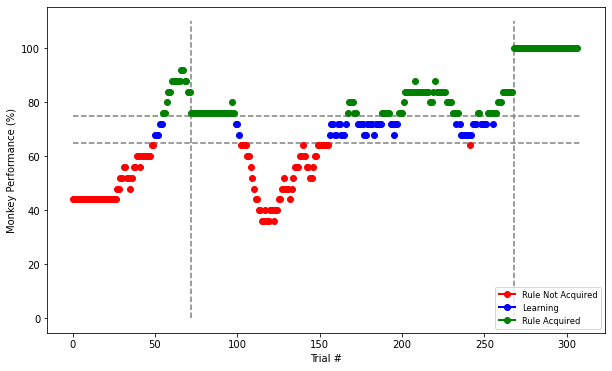

In [88]:
s_idx = 5
if s_idx == 8:
    chunk = 2
else:
    chunk = 1
sess_info = sess_infos[s_idx]
sess_id = sess_info['exp_code']
sess_id = sess_id.replace("+", "") + "_v1_segmented.h5"
segmented_path = data_path / sess_id
segmented_data = from_neuropype_h5(segmented_path)
outcome = np.array(segmented_data[chunk][1]['axes'][0]['data']['OutcomeCode'])
flag = np.argwhere(outcome>-1).flatten()
outcome = outcome[flag]
Y = np.array(segmented_data[chunk][1]['axes'][0]['data']['TargetClass']).flatten()[flag]
X_rates = segmented_data[chunk][1]['data'][flag]
X_rates = np.nan_to_num(X_rates)
#     X_rates = np.transpose(X_rates, (0, 2, 1))
block = np.array(segmented_data[chunk][1]['axes'][0]['data']['Block']).flatten()[flag]
b=np.diff(block, axis=0)
border=np.array(np.where(b>0)).flatten()
to_keep = [0]
for i in range(len(border) - 1):
    if (border[i + 1] - border[i]) > 30 and (len(outcome)-border[i+1]) > 30:
        to_keep.append(i + 1)
border = border[to_keep]
# to_keep = []
# for i in range(len(border)-1):
#     if i==0 and border[i] > 30:
#         to_keep = to_keep + list(range(border[i]))
#     elif (border[i + 1] - border[i]) > 30:
#         to_keep = to_keep + list(range(border[i], border[i+1]))
# if len(outcome)-border[-1]>30:
#     to_keep = to_keep + list(range(border[-1],len(outcome)))
color = np.array(segmented_data[chunk][1]['axes'][0]['data']['CueColour']).flatten()[flag]
target = np.array(segmented_data[chunk][1]['axes'][0]['data']['TargetRule']).flatten()[flag]
classes = np.array(segmented_data[chunk][1]['axes'][0]['data']['TargetClass']).flatten()[flag]
# X_rates = X_rates[to_keep]
# Y = Y[to_keep]
# Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
# color = color[to_keep]
# target = target[to_keep]
# classes = classes[to_keep]

# block = block[to_keep]
# b=np.diff(block, axis=0)
# border=np.array(np.where(b>0)).flatten()
# to_keep = [0]
# for i in range(len(border) - 1):
#     if (border[i + 1] - border[i]) > 30 and (len(outcome)-border[i+1]) > 30:
#         to_keep.append(i + 1)
# border = border[to_keep]
times = np.array(segmented_data[chunk][1]['axes'][1]['times']).flatten()
idx = np.argwhere(times < 1.45).flatten()[-1]
rule = np.zeros(np.size(X_rates,0))
for i in range(len(rule)):
    if (target[i]=='UU'):
        if (color[i] == 'r'):
            rule[i]=0
        elif(color[i] == 'g'):
            rule[i]=1
        else:
            rule[i]=2
    elif (target[i]=='UR'):
        if (color[i] == 'r'):
            rule[i]=3
        elif(color[i] == 'g'):
            rule[i]=4
        else:
            rule[i]=5
    elif (target[i]=='RR'):
        if (color[i] == 'r'):
            rule[i]=6
        elif(color[i] == 'g'):
            rule[i]=7
        else:
            rule[i]=8
    elif (target[i]=='DR'):
        if (color[i] == 'r'):
            rule[i]=9
        elif(color[i] == 'g'):
            rule[i]=10
        else:
            rule[i]=11
    elif (target[i]=='DD'):
        if (color[i] == 'r'):
            rule[i]=12
        elif(color[i] == 'g'):
            rule[i]=13
        else:
            rule[i]=14
    elif (target[i]=='DL'):
        if (color[i] == 'r'):
            rule[i]=15
        elif(color[i] == 'g'):
            rule[i]=16
        else:
            rule[i]=17
    elif (target[i]=='LL'):
        if (color[i] == 'r'):
            rule[i]=18
        elif(color[i] == 'g'):
            rule[i]=19
        else:
            rule[i]=20
    elif (target[i]=='UL'):
        if (color[i] == 'r'):
            rule[i]=21
        elif(color[i] == 'g'):
            rule[i]=22
        else:
            rule[i]=23
rule = rule.astype(int)
#     tmp = rule
#     _yu = np.unique(rule)
#     for i in range(len(tmp)):
#         rule[i] = np.where(_yu == tmp[i])[0][0]

m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

# for i in range(len(m_performance)):
#     if m_performance[i]<0:
#         m_performance[i] = 0
learned = np.argwhere(m_performance>75).flatten()
unlearned = np.argwhere(m_performance<65).flatten()
cor = np.array(np.where(outcome==0)).flatten()
icor = np.array(np.where(outcome==9)).flatten()
ic_l = []
c_l = []
ic_ul = []
for c in cor:
    if c in learned:
        c_l.append(c)
for ic in icor:
    if ic in unlearned:
        ic_ul.append(ic)
    else:
        ic_l.append(ic)
X_rates = X_rates[:, :, :idx+1]
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)


    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')

ax.hlines(y=65, xmin=0, xmax=len(m_performance)+1, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=len(m_performance)+1, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
b = [0] + list(border)
b.append(len(outcome))
for i in range(len(b)-1):
    print(f'Block: {i+1}')
    u, count = np.unique(target[b[i]:b[i+1]-1], return_counts=True)
    count_sort_ind = np.argsort(-count)
    targ = u[count_sort_ind]
    u, count = np.unique(color[b[i]:b[i+1]-1], return_counts=True)
    count_sort_ind = np.argsort(-count)
    colr = u[count_sort_ind]
    u, count = np.unique(rule[b[i]:b[i+1]-1], return_counts=True)
    count_sort_ind = np.argsort(-count)
    rul = u[count_sort_ind]
    print(f'Rule {rul[0]}: {targ[0]} & {colr[0]}')
    print(f'Rule {rul[1]}: {targ[1]} & {colr[1]}')

In [82]:
len(rule)

513

In [80]:
b

[0, 44, 212, 255, 384, 433, 598, 640, 681]

In [68]:
b

[0, 156, 283, 378, 592, 801, 874, 955, 1059, 1140, 1270]

In [72]:
idx=[]
block = 1
for c in learned:
    if c > b[block-1] and c < b[block]:
        idx.append(c)
x = X_rates[idx,:,:].reshape(len(idx),-1, order='F')
y = rule[idx]

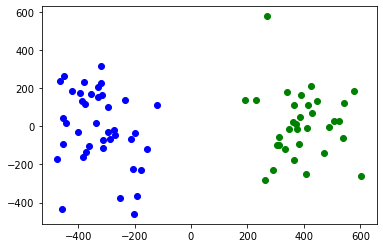

In [73]:
pca = PCA(n_components=2)
ls = pca.fit_transform(x)
for i in range(len(ls)):
    if y[i] == 2:
        c = 'green'
    else:
        c='blue'
    plt.plot(ls[i,0],ls[i,1],marker='o',color=c)

In [70]:
idx=[]
b_id = 0
for c in learned:
    if c > border[b_id] and c < border[b_id+1]:
        idx.append(c)
x = X_rates[idx,:,:].reshape(len(idx),-1, order='F')
y = rule[idx]

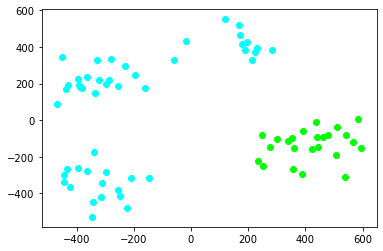

In [71]:
# pca2 = PCA(n_components=2)
ls2 = pca.fit_transform(x)

for i in range(len(ls2)):
    if y[i] == 2:
        c = 'lime'
    else:
        c='cyan'
    plt.plot(ls2[i,0],ls2[i,1],marker='o',color=c)

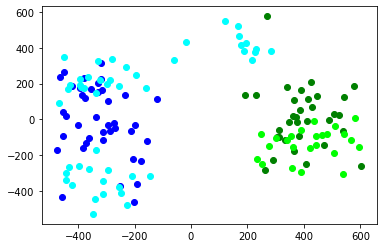

In [75]:
idx=[]
block = 1
for c in learned:
    if c > b[block-1] and c < b[block]:
        idx.append(c)
x = X_rates[idx,:,:].reshape(len(idx),-1, order='F')
y = rule[idx]
pca = PCA(n_components=2)
ls = pca.fit_transform(x)
for i in range(len(ls)):
    if y[i] == 2:
        c = 'green'
    else:
        c='blue'
    plt.plot(ls[i,0],ls[i,1],marker='o',color=c)
idx = np.argwhere(y==2).flatten()
green = np.array(ls[idx])
g_cent = np.mean(green, axis=0)
idx=[]
b_id = 0
for c in learned:
    if c > border[b_id] and c < border[b_id+1]:
        idx.append(c)
x = X_rates[idx,:,:].reshape(len(idx),-1, order='F')
y = rule[idx]
ls2 = pca.fit_transform(x)
for i in range(len(ls2)):
    if y[i] == 2:
        c = 'lime'
    else:
        c='cyan'
    plt.plot(ls2[i,0],ls2[i,1],marker='o',color=c)


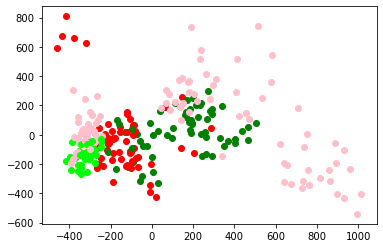

In [76]:
idx=[]
block = 4
for c in learned:
    if c > b[block-1] and c < b[block]:
        idx.append(c)
x = X_rates[idx,:,:].reshape(len(idx),-1, order='F')
y = rule[idx]
pca = PCA(n_components=2)
ls = pca.fit_transform(x)
for i in range(len(ls)):
    if y[i] == 18:
        c = 'green'
    else:
        c='red'
    plt.plot(ls[i,0],ls[i,1],marker='o',color=c)

idx=[]
block = 5
for c in learned:
    if c > b[block-1] and c < b[block]:
        idx.append(c)
x = X_rates[idx,:,:].reshape(len(idx),-1, order='F')
y = rule[idx]
ls2 = pca.fit_transform(x)
for i in range(len(ls2)):
    if y[i] == 18:
        c = 'lime'
    else:
        c='pink'
    plt.plot(ls2[i,0],ls2[i,1],marker='o',color=c)

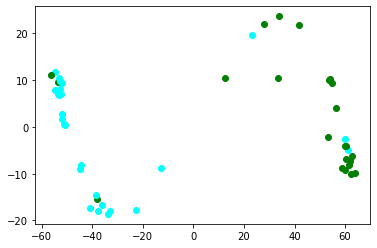

In [36]:
ls2 = pca2.fit_transform(x)
for i in range(len(ls2)):
    if rule[i + border[6]] == 23:
        c = 'cyan'
    else:
        c='green'
    plt.plot(ls2[i,0],ls2[i,1],marker='o',color=c)

In [9]:
indexes = np.unique(rule, return_index=True)[1]
[rule[index] for index in sorted(indexes)]

[13, 2, 3, 9, 23, 15, 17, 4, 7, 18, 12, 0, 10, 1]

# SVM

In [5]:
N_SPLITS = 10
# accuracies = []
# accuracies_chance = []

for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_rates, _, rule, _, _, c_l, _ = load_session(sess)
    X_rates = X_rates[c_l]
    Y_class = rule[c_l]
    tmp = Y_class
    _yu = np.unique(Y_class)
    for i in range(len(tmp)):
        Y_class[i] = np.where(_yu == tmp[i])[0][0]
    Y_shuf = np.random.permutation(Y_class)

    
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    acc=[]
    for run in range(20):
        i = 1
        tmp = []
        kf = KFold(n_splits=N_SPLITS)
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = Y_class[train_index], Y_class[test_index]
            clf = SVC(random_state=0, verbose=0).fit(x_tr, y_tr)
            y_prd = clf.predict(x_ts)
            tmp.append(y_prd)
        #     print (f'Fold #{i} Accuracy is: {acc}')
            i+=1

        predicted = tmp[0]
        for i in range(1, N_SPLITS):
            predicted = np.concatenate((predicted, tmp[i]))

        acc.append(100 * np.sum(predicted == Y_class.flatten()) / len(predicted))
    acc_m = np.mean(np.array(acc))
    acc_e = np.std(np.array(acc))
    
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    acc_shuf=[]
    for run in range(20):
        i = 1
        tmp = []
        kf = KFold(n_splits=N_SPLITS)
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = Y_shuf[train_index], Y_shuf[test_index]
            clf = SVC(random_state=0, verbose=0).fit(x_tr, y_tr)
            y_prd = clf.predict(x_ts)
            tmp.append(y_prd)
        #     print (f'Fold #{i} Accuracy is: {acc}')
            i+=1

        predicted = tmp[0]
        for i in range(1, N_SPLITS):
            predicted = np.concatenate((predicted, tmp[i]))

        acc_shuf.append(100 * np.sum(predicted == Y_shuf.flatten()) / len(predicted))
    acc_shuf_m = np.mean(np.array(acc_shuf))
    acc_shuf_e = np.std(np.array(acc_shuf))
    print(f"{sess_id} overal average accuracy: {acc_m} with {acc_e} error.")
    print(f"{sess_id} chance average accuracy: {acc_shuf_m} with {acc_shuf_e} error\n\n")

#     accuracies.append(acc)
#     accuracies_chance.append(acc_shuf)

sra3_2_j_037_00+03 overal average accuracy: 49.15254237288136 with 7.105427357601002e-15 error.
sra3_2_j_037_00+03 chance average accuracy: 49.71751412429378 with 7.105427357601002e-15 error


sra3_1_j_050_00+ overal average accuracy: 66.9491525423729 with 1.4210854715202004e-14 error.
sra3_1_j_050_00+ chance average accuracy: 23.163841807909602 with 3.552713678800501e-15 error


sra3_1_j_051_00+ overal average accuracy: 53.48189415041783 with 0.0 error.
sra3_1_j_051_00+ chance average accuracy: 22.284122562674096 with 0.0 error


sra3_1_j_052_00+ overal average accuracy: 59.20000000000001 with 7.105427357601002e-15 error.
sra3_1_j_052_00+ chance average accuracy: 13.6 with 0.0 error


sra3_1_m_077_00+01 overal average accuracy: 45.070422535211264 with 0.0 error.
sra3_1_m_077_00+01 chance average accuracy: 18.30985915492958 with 3.552713678800501e-15 error


sra3_1_m_081_00+01 overal average accuracy: 33.07086614173228 with 0.0 error.
sra3_1_m_081_00+01 chance average accuracy: 25.9842

# RLR

In [6]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [7]:
N_SPLITS = 10
# accuracies = []
# accuracies_chance = []

for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_rates, _, rule, _, _, c_l, _ = load_session(sess)
    X_rates = X_rates[c_l]
    Y_class = rule[c_l]
    tmp = Y_class
    _yu = np.unique(Y_class)
    for i in range(len(tmp)):
        Y_class[i] = np.where(_yu == tmp[i])[0][0]
    Y_shuf = np.random.permutation(Y_class)

    
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    acc=[]
    for run in range(20):
        i = 1
        tmp = []
        kf = KFold(n_splits=N_SPLITS)
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = Y_class[train_index], Y_class[test_index]
            clf = LR(random_state=0, verbose=0).fit(x_tr, y_tr)
            y_prd = clf.predict(x_ts)
            tmp.append(y_prd)
        #     print (f'Fold #{i} Accuracy is: {acc}')
            i+=1

        predicted = tmp[0]
        for i in range(1, N_SPLITS):
            predicted = np.concatenate((predicted, tmp[i]))

        acc.append(100 * np.sum(predicted == Y_class.flatten()) / len(predicted))
    acc_m = np.mean(np.array(acc))
    acc_e = np.std(np.array(acc))
    
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    acc_shuf=[]
    for run in range(20):
        i = 1
        tmp = []
        kf = KFold(n_splits=N_SPLITS)
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = Y_shuf[train_index], Y_shuf[test_index]
            clf = LR(random_state=0, verbose=0).fit(x_tr, y_tr)
            y_prd = clf.predict(x_ts)
            tmp.append(y_prd)
        #     print (f'Fold #{i} Accuracy is: {acc}')
            i+=1

        predicted = tmp[0]
        for i in range(1, N_SPLITS):
            predicted = np.concatenate((predicted, tmp[i]))

        acc_shuf.append(100 * np.sum(predicted == Y_shuf.flatten()) / len(predicted))
    acc_shuf_m = np.mean(np.array(acc_shuf))
    acc_shuf_e = np.std(np.array(acc_shuf))
    print(f"{sess_id} overal average accuracy: {acc_m} with {acc_e} error.")
    print(f"{sess_id} chance average accuracy: {acc_shuf_m} with {acc_shuf_e} error\n\n")

sra3_2_j_037_00+03 overal average accuracy: 51.977401129943495 with 7.105427357601002e-15 error.
sra3_2_j_037_00+03 chance average accuracy: 43.502824858757066 with 7.105427357601002e-15 error


sra3_1_j_050_00+ overal average accuracy: 74.29378531073445 with 1.4210854715202004e-14 error.
sra3_1_j_050_00+ chance average accuracy: 17.514124293785308 with 3.552713678800501e-15 error


sra3_1_j_051_00+ overal average accuracy: 57.938718662952645 with 0.0 error.
sra3_1_j_051_00+ chance average accuracy: 15.041782729805012 with 1.7763568394002505e-15 error


sra3_1_j_052_00+ overal average accuracy: 65.20000000000002 with 1.4210854715202004e-14 error.
sra3_1_j_052_00+ chance average accuracy: 13.6 with 0.0 error


sra3_1_m_077_00+01 overal average accuracy: 57.74647887323945 with 7.105427357601002e-15 error.
sra3_1_m_077_00+01 chance average accuracy: 22.535211267605632 with 0.0 error


sra3_1_m_081_00+01 overal average accuracy: 29.921259842519685 with 0.0 error.
sra3_1_m_081_00+01 chance 

# RF

In [8]:
N_SPLITS = 10
# accuracies = []
# accuracies_chance = []

for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_rates, _, rule, _, _, c_l, _ = load_session(sess)
    X_rates = X_rates[c_l]
    Y_class = rule[c_l]
    tmp = Y_class
    _yu = np.unique(Y_class)
    for i in range(len(tmp)):
        Y_class[i] = np.where(_yu == tmp[i])[0][0]
    Y_shuf = np.random.permutation(Y_class)

    
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    acc=[]
    for run in range(20):
        i = 1
        tmp = []
        kf = KFold(n_splits=N_SPLITS)
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = Y_class[train_index], Y_class[test_index]
            clf = RandomForestClassifier(max_depth=6, random_state=0).fit(x_tr, y_tr)
            y_prd = clf.predict(x_ts)
            tmp.append(y_prd)
        #     print (f'Fold #{i} Accuracy is: {acc}')
            i+=1

        predicted = tmp[0]
        for i in range(1, N_SPLITS):
            predicted = np.concatenate((predicted, tmp[i]))

        acc.append(100 * np.sum(predicted == Y_class.flatten()) / len(predicted))
    acc_m = np.mean(np.array(acc))
    acc_e = np.std(np.array(acc))
    
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    acc_shuf=[]
    for run in range(20):
        i = 1
        tmp = []
        kf = KFold(n_splits=N_SPLITS)
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = Y_shuf[train_index], Y_shuf[test_index]
            clf = RandomForestClassifier(max_depth=6, random_state=0).fit(x_tr, y_tr)
            y_prd = clf.predict(x_ts)
            tmp.append(y_prd)
        #     print (f'Fold #{i} Accuracy is: {acc}')
            i+=1

        predicted = tmp[0]
        for i in range(1, N_SPLITS):
            predicted = np.concatenate((predicted, tmp[i]))

        acc_shuf.append(100 * np.sum(predicted == Y_shuf.flatten()) / len(predicted))
    acc_shuf_m = np.mean(np.array(acc_shuf))
    acc_shuf_e = np.std(np.array(acc_shuf))
    print(f"{sess_id} overal average accuracy: {acc_m} with {acc_e} error.")
    print(f"{sess_id} chance average accuracy: {acc_shuf_m} with {acc_shuf_e} error\n\n")

sra3_2_j_037_00+03 overal average accuracy: 48.58757062146892 with 7.105427357601002e-15 error.
sra3_2_j_037_00+03 chance average accuracy: 49.15254237288136 with 7.105427357601002e-15 error


sra3_1_j_050_00+ overal average accuracy: 60.169491525423744 with 1.4210854715202004e-14 error.
sra3_1_j_050_00+ chance average accuracy: 20.056497175141246 with 3.552713678800501e-15 error


sra3_1_j_051_00+ overal average accuracy: 60.44568245125349 with 7.105427357601002e-15 error.
sra3_1_j_051_00+ chance average accuracy: 18.94150417827298 with 3.552713678800501e-15 error


sra3_1_j_052_00+ overal average accuracy: 58.40000000000001 with 1.4210854715202004e-14 error.
sra3_1_j_052_00+ chance average accuracy: 12.800000000000002 with 1.7763568394002505e-15 error


sra3_1_m_077_00+01 overal average accuracy: 44.3661971830986 with 7.105427357601002e-15 error.
sra3_1_m_077_00+01 chance average accuracy: 23.943661971830984 with 0.0 error


sra3_1_m_081_00+01 overal average accuracy: 37.795275590551

# DNN

In [9]:
accs = []
verbose=0
N_SPLITS = 10
EPOCHS = 100
for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_rates, _, rule, _, _, c_l, _ = load_session(sess)
    X_rates = X_rates[c_l]
    Y_class = rule[c_l]
    tmp = Y_class
    _yu = np.unique(Y_class)
    for i in range(len(tmp)):
        Y_class[i] = np.where(_yu == tmp[i])[0][0]
    print(f'\nSess: {sess}')
    _, tmp, _, _ = kfold_pred(sess_id,X_rates,Y_class,name=f'r2r_{sess}', verbose=verbose)
    accs.append(tmp)


Sess: 0
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 59.887005649717516%



Sess: 1
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 88.13559322033899%



Sess: 2
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 81.33704735376044%



Sess: 3
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 83.2%



Sess: 4
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 67.6056338028169%



Sess: 5
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Spl

In [26]:
with open('accs_r2r.pkl', 'rb') as f:
    accs = np.array(pickle.load(f))
with open('accs_r2r_chance.pkl', 'rb') as f:
    accs_shuf = np.array(pickle.load(f))

In [29]:
for i in range(9):
    sess_info = sess_infos[i]
    sess_id = sess_info['exp_code']
    acc = accs[i]
    acc_shuf = accs_shuf[i]
    acc_m = np.mean(np.array(acc))
    acc_e = np.std(np.array(acc))
    acc_shuf_m = np.mean(np.array(acc_shuf))
    acc_shuf_e = np.std(np.array(acc_shuf))
    print(f"{sess_id} overal average accuracy: {acc_m} with {acc_e} error.")
    print(f"{sess_id} chance average accuracy: {acc_shuf_m} with {acc_shuf_e} error\n\n")

sra3_2_j_037_00+03 overal average accuracy: 58.589108910891106 with 1.1100043230088448 error.
sra3_2_j_037_00+03 chance average accuracy: 55.96534653465346 with 1.1868289202709748 error


sra3_1_j_050_00+ overal average accuracy: 79.51776649746193 with 0.8722253947938905 error.
sra3_1_j_050_00+ chance average accuracy: 24.670050761421315 with 0.7338493550660389 error


sra3_1_j_051_00+ overal average accuracy: 72.88220551378446 with 0.818287103624788 error.
sra3_1_j_051_00+ chance average accuracy: 25.651629072681704 with 0.92519909580362 error


sra3_1_j_052_00+ overal average accuracy: 74.20962199312714 with 0.9187219508793739 error.
sra3_1_j_052_00+ chance average accuracy: 26.374570446735397 with 1.069579003263637 error


sra3_1_m_077_00+01 overal average accuracy: 62.48344370860927 with 1.3616480261557673 error.
sra3_1_m_077_00+01 chance average accuracy: 38.77483443708609 with 1.7705171371251456 error


sra3_1_m_081_00+01 overal average accuracy: 49.01360544217687 with 1.46653477

In [30]:
np.zeros(8)+1.7e-9

array([1.7e-09, 1.7e-09, 1.7e-09, 1.7e-09, 1.7e-09, 1.7e-09, 1.7e-09,
       1.7e-09])

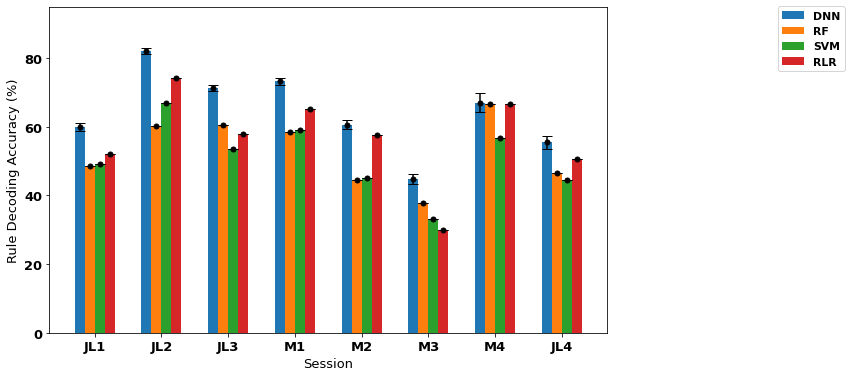

In [41]:
import matplotlib
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

sessions = ['JL1', 'JL2', 'JL3', 'M1', 'M2', 'M3', 'M4', 'JL4']
x = np.arange(0, 2*len(sessions), 2)  # the label locations
width = 0.3
acc_dnn = np.array([59.88, 82.14, 71.34, 73.2, 60.61, 44.88, 67, 55.45])
acc_svm = np.array([49.15, 66.95, 53.48, 59.2, 45.07, 33.07, 56.67, 44.55])
acc_rlr = np.array([51.98, 74.29, 57.94, 65.2, 57.75, 29.92, 66.67, 50.49])
acc_rf = np.array([48.59, 60.17, 60.45, 58.4, 44.37, 37.8, 66.67, 46.53])

err_dnn = np.array([1.11, 0.87, 0.82, 0.92, 1.36, 1.47, 2.74, 1.90])
err_svm = np.zeros(8)+1.7e-9
err_rlr = np.zeros(8)+1.7e-9
err_rf = np.zeros(8)+1.7e-9

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - 3*width/2, acc_dnn, width, label='DNN')
rects2 = ax.bar(x - width/2, acc_rf, width, label='RF')
rects4 = ax.bar(x + width/2, acc_svm, width, label='SVM')
rects3 = ax.bar(x + 3*width/2, acc_rlr, width, label='RLR')
plt.errorbar(x - 3*width/2, acc_dnn, yerr=err_dnn, fmt='.', markersize='10', capsize=5, color='black')
plt.errorbar(x - width/2, acc_rf, yerr=err_rf, fmt='.', markersize='10', capsize=5, color='black')
plt.errorbar(x + width/2, acc_svm, yerr=err_svm, fmt='.', markersize='10', capsize=5, color='black')
plt.errorbar(x + 3*width/2, acc_rlr, yerr=err_rlr, fmt='.', markersize='10', capsize=5, color='black')

ax.set_ylim([0, 95])
ax.set_ylabel('Rule Decoding Accuracy (%)')
ax.set_xlabel('Session')
ax.set_xticks(x)
ax.set_xticklabels(sessions)
ax.legend(loc='lower right', bbox_to_anchor=(1.435, .785), fontsize='small')
fig.savefig("rule_performance.svg")

# Saccade

In [5]:
T_MAX = 1.45

# SVM

In [29]:
N_SPLITS = 10
# accuracies = []
# accuracies_chance = []

for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_rates, Y, _, _, _, c_l, _ = load_session(sess,t_end=T_MAX)
    X_rates = X_rates[c_l]
    Y_class = Y[c_l]
    tmp = Y_class
    _yu = np.unique(Y_class)
    for i in range(len(tmp)):
        Y_class[i] = np.where(_yu == tmp[i])[0][0]
    Y_shuf = np.random.permutation(Y_class)

    
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    acc=[]
    for run in range(20):
        i = 1
        tmp = []
        kf = KFold(n_splits=N_SPLITS)
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = Y_class[train_index], Y_class[test_index]
            clf = SVC(random_state=0, verbose=0).fit(x_tr, y_tr)
            y_prd = clf.predict(x_ts)
            tmp.append(y_prd)
        #     print (f'Fold #{i} Accuracy is: {acc}')
            i+=1

        predicted = tmp[0]
        for i in range(1, N_SPLITS):
            predicted = np.concatenate((predicted, tmp[i]))

        acc.append(100 * np.sum(predicted == Y_class.flatten()) / len(predicted))
    acc_m = np.mean(np.array(acc))
    acc_e = np.std(np.array(acc))
    
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    acc_shuf=[]
    for run in range(20):
        i = 1
        tmp = []
        kf = KFold(n_splits=N_SPLITS)
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = Y_shuf[train_index], Y_shuf[test_index]
            clf = SVC(random_state=0, verbose=0).fit(x_tr, y_tr)
            y_prd = clf.predict(x_ts)
            tmp.append(y_prd)
        #     print (f'Fold #{i} Accuracy is: {acc}')
            i+=1

        predicted = tmp[0]
        for i in range(1, N_SPLITS):
            predicted = np.concatenate((predicted, tmp[i]))

        acc_shuf.append(100 * np.sum(predicted == Y_shuf.flatten()) / len(predicted))
    acc_shuf_m = np.mean(np.array(acc_shuf))
    acc_shuf_e = np.std(np.array(acc_shuf))
    print(f"{sess_id} overal average accuracy: {acc_m} with {acc_e} error.")
    print(f"{sess_id} chance average accuracy: {acc_shuf_m} with {acc_shuf_e} error\n\n")

#     accuracies.append(acc)
#     accuracies_chance.append(acc_shuf)

sra3_2_j_037_00+03 overal average accuracy: 53.672316384180796 with 7.105427357601002e-15 error.
sra3_2_j_037_00+03 chance average accuracy: 54.802259887005654 with 7.105427357601002e-15 error


sra3_1_j_050_00+ overal average accuracy: 74.57627118644066 with 1.4210854715202004e-14 error.
sra3_1_j_050_00+ chance average accuracy: 22.316384180790966 with 3.552713678800501e-15 error


sra3_1_j_051_00+ overal average accuracy: 63.50974930362118 with 7.105427357601002e-15 error.
sra3_1_j_051_00+ chance average accuracy: 21.448467966573823 with 7.105427357601002e-15 error


sra3_1_j_052_00+ overal average accuracy: 60.0 with 0.0 error.
sra3_1_j_052_00+ chance average accuracy: 26.0 with 0.0 error


sra3_1_m_077_00+01 overal average accuracy: 25.352112676056336 with 3.552713678800501e-15 error.
sra3_1_m_077_00+01 chance average accuracy: 24.647887323943664 with 3.552713678800501e-15 error


sra3_1_m_081_00+01 overal average accuracy: 32.28346456692914 with 7.105427357601002e-15 error.
sra3_1

# RLR

In [30]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [31]:
N_SPLITS = 10
# accuracies = []
# accuracies_chance = []

for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_rates, Y, _, _, _, c_l, _ = load_session(sess,t_end=T_MAX)
    X_rates = X_rates[c_l]
    Y_class = Y[c_l]
    tmp = Y_class
    _yu = np.unique(Y_class)
    for i in range(len(tmp)):
        Y_class[i] = np.where(_yu == tmp[i])[0][0]
    Y_shuf = np.random.permutation(Y_class)

    
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    acc=[]
    for run in range(20):
        i = 1
        tmp = []
        kf = KFold(n_splits=N_SPLITS)
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = Y_class[train_index], Y_class[test_index]
            clf = LR(random_state=0, verbose=0).fit(x_tr, y_tr)
            y_prd = clf.predict(x_ts)
            tmp.append(y_prd)
        #     print (f'Fold #{i} Accuracy is: {acc}')
            i+=1

        predicted = tmp[0]
        for i in range(1, N_SPLITS):
            predicted = np.concatenate((predicted, tmp[i]))

        acc.append(100 * np.sum(predicted == Y_class.flatten()) / len(predicted))
    acc_m = np.mean(np.array(acc))
    acc_e = np.std(np.array(acc))
    
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    acc_shuf=[]
    for run in range(20):
        i = 1
        tmp = []
        kf = KFold(n_splits=N_SPLITS)
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = Y_shuf[train_index], Y_shuf[test_index]
            clf = LR(random_state=0, verbose=0).fit(x_tr, y_tr)
            y_prd = clf.predict(x_ts)
            tmp.append(y_prd)
        #     print (f'Fold #{i} Accuracy is: {acc}')
            i+=1

        predicted = tmp[0]
        for i in range(1, N_SPLITS):
            predicted = np.concatenate((predicted, tmp[i]))

        acc_shuf.append(100 * np.sum(predicted == Y_shuf.flatten()) / len(predicted))
    acc_shuf_m = np.mean(np.array(acc_shuf))
    acc_shuf_e = np.std(np.array(acc_shuf))
    print(f"{sess_id} overal average accuracy: {acc_m} with {acc_e} error.")
    print(f"{sess_id} chance average accuracy: {acc_shuf_m} with {acc_shuf_e} error\n\n")

sra3_2_j_037_00+03 overal average accuracy: 57.62711864406781 with 7.105427357601002e-15 error.
sra3_2_j_037_00+03 chance average accuracy: 47.45762711864406 with 7.105427357601002e-15 error


sra3_1_j_050_00+ overal average accuracy: 80.22598870056498 with 1.4210854715202004e-14 error.
sra3_1_j_050_00+ chance average accuracy: 14.689265536723164 with 0.0 error


sra3_1_j_051_00+ overal average accuracy: 64.62395543175488 with 0.0 error.
sra3_1_j_051_00+ chance average accuracy: 29.247910863509752 with 3.552713678800501e-15 error


sra3_1_j_052_00+ overal average accuracy: 56.4 with 0.0 error.
sra3_1_j_052_00+ chance average accuracy: 22.0 with 0.0 error


sra3_1_m_077_00+01 overal average accuracy: 37.32394366197183 with 0.0 error.
sra3_1_m_077_00+01 chance average accuracy: 20.4225352112676 with 3.552713678800501e-15 error


sra3_1_m_081_00+01 overal average accuracy: 37.00787401574803 with 0.0 error.
sra3_1_m_081_00+01 chance average accuracy: 25.984251968503933 with 3.5527136788005

# RF

In [32]:
N_SPLITS = 10
# accuracies = []
# accuracies_chance = []

for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_rates, Y, _, _, _, c_l, _ = load_session(sess,t_end=T_MAX)
    X_rates = X_rates[c_l]
    Y_class = Y[c_l]
    tmp = Y_class
    _yu = np.unique(Y_class)
    for i in range(len(tmp)):
        Y_class[i] = np.where(_yu == tmp[i])[0][0]
    Y_shuf = np.random.permutation(Y_class)

    
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    acc=[]
    for run in range(20):
        i = 1
        tmp = []
        kf = KFold(n_splits=N_SPLITS)
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = Y_class[train_index], Y_class[test_index]
            clf = RandomForestClassifier(max_depth=6, random_state=0).fit(x_tr, y_tr)
            y_prd = clf.predict(x_ts)
            tmp.append(y_prd)
        #     print (f'Fold #{i} Accuracy is: {acc}')
            i+=1

        predicted = tmp[0]
        for i in range(1, N_SPLITS):
            predicted = np.concatenate((predicted, tmp[i]))

        acc.append(100 * np.sum(predicted == Y_class.flatten()) / len(predicted))
    acc_m = np.mean(np.array(acc))
    acc_e = np.std(np.array(acc))
    
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    acc_shuf=[]
    for run in range(20):
        i = 1
        tmp = []
        kf = KFold(n_splits=N_SPLITS)
        for train_index, test_index in kf.split(X):
            x_tr, x_ts = X[train_index], X[test_index]
            y_tr, y_ts = Y_shuf[train_index], Y_shuf[test_index]
            clf = RandomForestClassifier(max_depth=6, random_state=0).fit(x_tr, y_tr)
            y_prd = clf.predict(x_ts)
            tmp.append(y_prd)
        #     print (f'Fold #{i} Accuracy is: {acc}')
            i+=1

        predicted = tmp[0]
        for i in range(1, N_SPLITS):
            predicted = np.concatenate((predicted, tmp[i]))

        acc_shuf.append(100 * np.sum(predicted == Y_shuf.flatten()) / len(predicted))
    acc_shuf_m = np.mean(np.array(acc_shuf))
    acc_shuf_e = np.std(np.array(acc_shuf))
    print(f"{sess_id} overal average accuracy: {acc_m} with {acc_e} error.")
    print(f"{sess_id} chance average accuracy: {acc_shuf_m} with {acc_shuf_e} error\n\n")

sra3_2_j_037_00+03 overal average accuracy: 50.84745762711864 with 7.105427357601002e-15 error.
sra3_2_j_037_00+03 chance average accuracy: 51.41242937853108 with 7.105427357601002e-15 error


sra3_1_j_050_00+ overal average accuracy: 63.27683615819209 with 0.0 error.
sra3_1_j_050_00+ chance average accuracy: 22.881355932203395 with 3.552713678800501e-15 error


sra3_1_j_051_00+ overal average accuracy: 64.34540389972146 with 1.4210854715202004e-14 error.
sra3_1_j_051_00+ chance average accuracy: 25.626740947075213 with 3.552713678800501e-15 error


sra3_1_j_052_00+ overal average accuracy: 52.79999999999999 with 7.105427357601002e-15 error.
sra3_1_j_052_00+ chance average accuracy: 23.199999999999996 with 3.552713678800501e-15 error


sra3_1_m_077_00+01 overal average accuracy: 17.6056338028169 with 0.0 error.
sra3_1_m_077_00+01 chance average accuracy: 19.01408450704225 with 3.552713678800501e-15 error


sra3_1_m_081_00+01 overal average accuracy: 40.94488188976378 with 0.0 error.
sr

# DNN

In [33]:
accs = []
verbose=0
N_SPLITS = 10
EPOCHS = 100
for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_rates, Y, _, _, _, c_l, _ = load_session(sess,t_end=T_MAX)
    X_rates = X_rates[c_l]
    Y_class = Y[c_l]
    tmp = Y_class
    _yu = np.unique(Y_class)
    for i in range(len(tmp)):
        Y_class[i] = np.where(_yu == tmp[i])[0][0]
    print(f'\nSess: {sess}')
    _, tmp, _, _ = kfold_pred(sess_id,X_rates,Y_class,name=f'r2s_{sess}', verbose=verbose)
    accs.append(tmp)


Sess: 0
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 71.75141242937853%



Sess: 1
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 76.27118644067797%



Sess: 2
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 82.72980501392757%



Sess: 3
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 80.0%



Sess: 4
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 54.225352112676056%



Sess: 5
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Sp

In [8]:
accs = []
verbose=0
N_SPLITS = 10
EPOCHS = 100
for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_rates, Y, _, _, _, c_l, _ = load_session(sess,t_end=T_MAX)
    X_rates = X_rates[c_l]
    Y_class = Y[c_l]
    tmp = Y_class
    _yu = np.unique(Y_class)
    for i in range(len(tmp)):
        Y_class[i] = np.where(_yu == tmp[i])[0][0]
    print(f'\nSess: {sess}')
    _, tmp, _, _ = kfold_pred(sess_id,X_rates,Y_class,name=f'r2s_{sess}', verbose=verbose)
    accs.append(tmp)


Sess: 0
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 67.2316384180791%



Sess: 1
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 85.31073446327683%



Sess: 2
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 82.45125348189416%



Sess: 3
	Split 1 of 10


C:\Users\Alireza\miniconda3\envs\dl\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 74.4%



Sess: 4
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 55.63380281690141%



Sess: 5
	Split 1 of 10


C:\Users\Alireza\miniconda3\envs\dl\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 53.54330708661417%



Sess: 6
	Split 1 of 10


C:\Users\Alireza\miniconda3\envs\dl\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 73.33333333333333%



Sess: 7
	Split 1 of 10


C:\Users\Alireza\miniconda3\envs\dl\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 64.35643564356435%




In [11]:
accs = []
verbose=0
N_SPLITS = 10
EPOCHS = 100
for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
    X_rates = np.transpose(X_rates, (0, 2, 1))
#     tmp = Y_class
#     _yu = np.unique(Y_class)
#     for i in range(len(tmp)):
#         Y_class[i] = np.where(_yu == tmp[i])[0][0]
    print(f'\nSess: {sess}')
    _, tmp, _, _ = kfold_pred(sess_id,X_rates,Y_class,name=f'r2s_{sess}', verbose=verbose)
    accs.append(tmp)


Sess: 0
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 70.85201793721973%



Sess: 1
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 81.98757763975155%



Sess: 2
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 76.87224669603525%



Sess: 3
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 66.97038724373576%



Sess: 4
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 41.791044776119406%



Sess: 5
	Split 1 of 10
	Split 2 of 10
	Spli

In [12]:
model_kwargs1 = dict(
    filt=8,
    kernLength=20,
#     ds_rate=5,
    n_rnn=64,
    n_rnn2=0,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)

load_kwargs = {
    'valid_outcomes': (0, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

In [13]:
def make_model2(
    _input,
    num_classes,
    filt=8,
    kernLength=25,
    ds_rate=10,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.25,
    activation='relu',
    l1_reg=0.000, l2_reg=0.000,
    norm_rate=0.25,
    latent_dim=16,
    return_model=True
):
    
    inputs = tf.keras.layers.Input(shape=_input.shape[1:])
    
    input_shape = list(_input.shape)
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    # input_shape[2] = -1  # Comment out during debug
    # _y = layers.Reshape(input_shape[1:])(_input)  # Note that Reshape ignores the batch dimension.

    # RNN
    if len(input_shape) < 4:
        input_shape = input_shape + [1]
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    _y = tf.keras.layers.Reshape(input_shape[1:])(inputs)
    _y = tf.keras.layers.Conv2D(filt, (1, kernLength), padding='valid', data_format=None,
                                dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
                                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.DepthwiseConv2D((_y.shape.as_list()[1], 1), padding='valid',
                                      depth_multiplier=1, data_format=None, dilation_rate=(1, 1),
                                      activation=None, use_bias=True, depthwise_initializer='glorot_uniform',
                                      bias_initializer='zeros', depthwise_regularizer=None,
                                      bias_regularizer=None, activity_regularizer=None,
                                      depthwise_constraint=None, bias_constraint=None)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.AveragePooling2D(pool_size=(1, ds_rate))(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    _y = tf.keras.layers.Reshape(_y.shape.as_list()[2:])(_y)
    _y = tf.keras.layers.LSTM(n_rnn,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=n_rnn2 > 0,
                              stateful=False,
                              name='rnn1')(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    
    if n_rnn2 > 0:
        
        _y = tf.keras.layers.LSTM(n_rnn2,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=False,
                              stateful=False,
                              name='rnn2')(_y)
        _y = tf.keras.layers.Activation(activation)(_y)
        _y = tf.keras.layers.BatchNormalization()(_y)
        _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    # Dense
    _y = tf.keras.layers.Dense(latent_dim, activation=activation)(_y)
#     _y = parts.Bottleneck(_y, latent_dim=latent_dim, activation=activation)
    
    # Classify
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(_y)
#     outputs = parts.Classify(_y, n_classes=num_classes, norm_rate=norm_rate)
    

    if return_model is False:
        return outputs
    else:
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [14]:
def get_hists_acc(sess_id, verbose=1):
    print(f"Processing session {sess_id}...")
    X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
    
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    split_ix = 0
    histories = []
    per_fold_eval = []
    per_fold_true = []

    for trn, vld in splitter.split(X_rates, Y_class):
        print(f"\tSplit {split_ix + 1} of {N_SPLITS}")
        _y = tf.keras.utils.to_categorical(Y_class, num_classes=8)
        
        ds_train = tf.data.Dataset.from_tensor_slices((X_rates[trn], _y[trn]))
        ds_valid = tf.data.Dataset.from_tensor_slices((X_rates[vld], _y[vld]))

        # cast data types to GPU-friendly types.
        ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

        # TODO: augmentations (random slicing?)

        ds_train = ds_train.shuffle(len(trn) + 1)
        ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
        ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

        tf.keras.backend.clear_session()
        
        randseed = 12345
        random.seed(randseed)
        np.random.seed(randseed)
        tf.random.set_seed(randseed)
        
        model = make_model2(X_rates, _y.shape[-1], **model_kwargs)
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
        
        best_model_path = f'r2c_lstm_{sess_id}_split{split_ix}.h5'
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=best_model_path,
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                save_best_only=True,
                monitor='val_accuracy',
                verbose=verbose)
        ]

        hist = model.fit(x=ds_train, epochs=EPOCHS,
                         verbose=verbose,
                         validation_data=ds_valid,
                         callbacks=callbacks)
        # tf.keras.models.save_model(model, 'model.h5')
        histories.append(hist.history)
        
        model = tf.keras.models.load_model(best_model_path)
        per_fold_eval.append(model(X_rates[vld]).numpy())
        per_fold_true.append(Y_class[vld])
        
        split_ix += 1
        
    # Combine histories into one dictionary.
    history = {}
    for h in histories:
        for k,v in h.items():
            if k not in history:
                history[k] = v
            else:
                history[k].append(np.nan)
                history[k].extend(v)
                
    pred_y = np.concatenate([np.argmax(_, axis=1) for _ in per_fold_eval])
    true_y = np.concatenate(per_fold_true).flatten()
    accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"\n\nSession {sess_id} overall accuracy with CNN/LSTM Model: {accuracy}%")
    
    return history, accuracy, pred_y, true_y

In [15]:
accs = []
verbose=0
N_SPLITS = 10
EPOCHS = 100
for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
#     X_rates = np.transpose(X_rates, (0, 2, 1))
#     tmp = Y_class
#     _yu = np.unique(Y_class)
#     for i in range(len(tmp)):
#         Y_class[i] = np.where(_yu == tmp[i])[0][0]
    _, tmp, _, _ = get_hists_acc(sess_id, verbose=verbose)
    accs.append(tmp)

Processing session sra3_2_j_037_00+03...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_2_j_037_00+03 overall accuracy with CNN/LSTM Model: 69.5067264573991%
Processing session sra3_1_j_050_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_050_00+ overall accuracy with CNN/LSTM Model: 86.33540372670808%
Processing session sra3_1_j_051_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 75.77092511013215%
Processing session sra3_1_j_052_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	

# Rule Confusion Matrix

In [34]:
accs = []
verbose=0
N_SPLITS = 10
EPOCHS = 100
for sess in [3]:
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_rates, _, rule, _, _, c_l, _ = load_session(sess)
    X_rates = X_rates[c_l]
    Y_class = rule[c_l]
    tmp = Y_class
    _yu = np.unique(Y_class)
    for i in range(len(tmp)):
        Y_class[i] = np.where(_yu == tmp[i])[0][0]
    print(f'\nSess: {sess}')
    _, _, y_pred, y_true = kfold_pred(sess_id,X_rates,Y_class,name=f'r2r_{sess}', verbose=verbose)
    b = np.zeros((np.max(Y_class)+1,np.max(Y_class)+1))
    for i in range(len(y_true)):
        b[y_true[i], y_pred[i]] += 1
    print(f'{b}\n')


Sess: 3
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 53.41296928327645%


[[  7.  14.   3.   2.   0.   5.   5.   0.   0.   0.]
 [  0. 113.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  48.   0.   1.   0.   0.   3.   8.   0.]
 [  0.   0.  22.   1.   1.   0.   0.   4.   7.   0.]
 [  0.   0.  14.   5.  30.   0.   2.   5.  16.   3.]
 [  2.   2.   9.   1.   0.  13.   2.   1.   6.   0.]
 [  0.  17.   3.   1.   0.   0.  64.   0.   1.   0.]
 [  0.   0.  17.   1.   0.   0.   0.   4.  17.   1.]
 [  0.   0.  23.   1.   1.   0.   0.   5.  21.   1.]
 [  0.   0.  10.   4.  18.   0.   0.   2.   7.  12.]]



In [29]:
sess=3
sess_info = sess_infos[sess]
sess_id = sess_info['exp_code']
X_rates, _, rule, _, _, c_l, _ = load_session(sess)
X_rates = X_rates[c_l]
Y_class = rule[c_l]
tmp = Y_class
_yu = np.unique(Y_class)
for i in range(len(tmp)):
    Y_class[i] = np.where(_yu == tmp[i])[0][0]
b = np.zeros((int(np.max(Y_class))+1,int(np.max(Y_class))+1))
for i in range(len(y_true)):
    b[y_true[i], y_pred[i]] += 1
print(f'{b}\n')

[[ 0.  0.  0.  0.  0.  3.  0.  0.  0.  0.]
 [ 0. 15.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 39.  4.  0.  0.  0.  0.  2.  0.]
 [ 0.  0.  8. 11.  0.  0.  0.  0.  3.  0.]
 [ 0.  0.  0.  0. 30.  0.  0.  0.  0.  2.]
 [ 0.  0.  0.  0.  0. 17.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 44.  0.  0.  0.]
 [ 0.  0.  3.  2.  0.  0.  0.  3.  2.  1.]
 [ 0.  0.  7.  0.  0.  0.  1.  0. 12.  0.]
 [ 0.  0.  0.  0.  3.  0.  0.  0.  0. 38.]]



In [35]:
c=b[[4,9,6,1,7,3,8,2,5,0],:]
c[:,[4,9,6,1,7,3,8,2,5,0]]

array([[ 30.,   3.,   2.,   0.,   5.,   5.,  16.,  14.,   0.,   0.],
       [ 18.,  12.,   0.,   0.,   2.,   4.,   7.,  10.,   0.,   0.],
       [  0.,   0.,  64.,  17.,   0.,   1.,   1.,   3.,   0.,   0.],
       [  0.,   0.,   0., 113.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.,   4.,   1.,  17.,  17.,   0.,   0.],
       [  1.,   0.,   0.,   0.,   4.,   1.,   7.,  22.,   0.,   0.],
       [  1.,   1.,   0.,   0.,   5.,   1.,  21.,  23.,   0.,   0.],
       [  1.,   0.,   0.,   0.,   3.,   0.,   8.,  48.,   0.,   0.],
       [  0.,   0.,   2.,   2.,   1.,   1.,   6.,   9.,  13.,   2.],
       [  0.,   0.,   5.,  14.,   0.,   2.,   0.,   3.,   5.,   7.]])

In [ ]:
for i in range(len(rule)):
        if (target[i]=='UU'):
            if (color[i] == 'r'):
                rule[i]=0
            elif(color[i] == 'g'):
                rule[i]=1
            else:
                rule[i]=2
        elif (target[i]=='UR'):
            if (color[i] == 'r'):
                rule[i]=3
            elif(color[i] == 'g'):
                rule[i]=4
            else:
                rule[i]=5
        elif (target[i]=='RR'):
            if (color[i] == 'r'):
                rule[i]=6
            elif(color[i] == 'g'):
                rule[i]=7
            else:
                rule[i]=8
        elif (target[i]=='DR'):
            if (color[i] == 'r'):
                rule[i]=9
            elif(color[i] == 'g'):
                rule[i]=10
            else:
                rule[i]=11
        elif (target[i]=='DD'):
            if (color[i] == 'r'):
                rule[i]=12
            elif(color[i] == 'g'):
                rule[i]=13
            else:
                rule[i]=14
        elif (target[i]=='DL'):
            if (color[i] == 'r'):
                rule[i]=15
            elif(color[i] == 'g'):
                rule[i]=16
            else:
                rule[i]=17
        elif (target[i]=='LL'):
            if (color[i] == 'r'):
                rule[i]=18
            elif(color[i] == 'g'):
                rule[i]=19
            else:
                rule[i]=20
        elif (target[i]=='UL'):
            if (color[i] == 'r'):
                rule[i]=21
            elif(color[i] == 'g'):
                rule[i]=22
            else:
                rule[i]=23

In [17]:
for sess in [1, 2, 3]:
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_rates, _, rule, _, _, c_l, _ = load_session(sess)
    X_rates = X_rates[c_l]
    Y_class = rule[c_l]
    print(f'{np.unique(Y_class)}\n')

[ 0  2  3  4  5  6  7  8  9 10 11 12 13]

[ 0  1  2  3  4  5  6  7  8  9 10]

[0 1 2 3 4 5 6 7 8 9]



In [23]:
s_idx = 3
t = np.inf
sess_info = sess_infos[s_idx]
sess_id = sess_info['exp_code']
sess_id = sess_id.replace("+", "")+"_v1" + "_segmented.h5"
segmented_path = data_path / sess_id
segmented_data = from_neuropype_h5(segmented_path)
outcome = np.array(segmented_data[2][1]['axes'][0]['data']['OutcomeCode'])
flag = np.argwhere(outcome>-1).flatten()
outcome = outcome[flag]
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()[flag]
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X_rates = segmented_data[2][1]['data'][flag]
X_rates = np.nan_to_num(X_rates)
X_rates = np.transpose(X_rates, (0, 2, 1))
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()[flag]
b=np.diff(block, axis=0)
border=np.array(np.where(b>0)).flatten()
to_keep = [0]
for i in range(len(border) - 1):
    if (border[i + 1] - border[i]) > 30 and (len(outcome)-border[i+1]) > 30:
        to_keep.append(i + 1)
border = border[to_keep]
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()[flag]
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()[flag]
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()[flag]
times = np.array(segmented_data[2][1]['axes'][1]['times']).flatten()
idx = np.argwhere(times < t).flatten()[-1]
rule = np.zeros(np.size(X_rates,0))
for i in range(len(rule)):
    if (target[i]=='UU'):
        if (color[i] == 'r'):
            rule[i]=0
        elif(color[i] == 'g'):
            rule[i]=1
        else:
            rule[i]=2
    elif (target[i]=='UR'):
        if (color[i] == 'r'):
            rule[i]=3
        elif(color[i] == 'g'):
            rule[i]=4
        else:
            rule[i]=5
    elif (target[i]=='RR'):
        if (color[i] == 'r'):
            rule[i]=6
        elif(color[i] == 'g'):
            rule[i]=7
        else:
            rule[i]=8
    elif (target[i]=='DR'):
        if (color[i] == 'r'):
            rule[i]=9
        elif(color[i] == 'g'):
            rule[i]=10
        else:
            rule[i]=11
    elif (target[i]=='DD'):
        if (color[i] == 'r'):
            rule[i]=12
        elif(color[i] == 'g'):
            rule[i]=13
        else:
            rule[i]=14
    elif (target[i]=='DL'):
        if (color[i] == 'r'):
            rule[i]=15
        elif(color[i] == 'g'):
            rule[i]=16
        else:
            rule[i]=17
    elif (target[i]=='LL'):
        if (color[i] == 'r'):
            rule[i]=18
        elif(color[i] == 'g'):
            rule[i]=19
        else:
            rule[i]=20
    elif (target[i]=='UL'):
        if (color[i] == 'r'):
            rule[i]=21
        elif(color[i] == 'g'):
            rule[i]=22
        else:
            rule[i]=23
rule = rule.astype(int)


m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
learned = np.argwhere(m_performance>75).flatten()
unlearned = np.argwhere(m_performance<65).flatten()
cor = np.array(np.where(outcome==0)).flatten()
icor = np.array(np.where(outcome==9)).flatten()
c_l = []
ic_ul = []
for c in cor:
    if c in learned:
        c_l.append(c)
for ic in icor:
    if ic in unlearned:
        ic_ul.append(ic)

In [24]:
np.unique(rule[c_l])

array([ 2,  3,  6,  8, 11, 12, 16, 18, 19, 21])

# Decoding Confidence

In [8]:
def kfold_prob(sess_id,X_rates,Y_class, verbose=1):
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    split_ix = 0
    histories = []
    per_fold_eval = []
    per_fold_true = []

    for trn, vld in splitter.split(X_rates, Y_class):
        print(f"\tSplit {split_ix + 1} of {N_SPLITS}")
        _y = tf.keras.utils.to_categorical(Y_class, num_classes=np.max(Y_class)+1)
        
        ds_train = tf.data.Dataset.from_tensor_slices((X_rates[trn], _y[trn]))
        ds_valid = tf.data.Dataset.from_tensor_slices((X_rates[vld], _y[vld]))

        # cast data types to GPU-friendly types.
        ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

        # TODO: augmentations (random slicing?)

        ds_train = ds_train.shuffle(len(trn) + 1)
        ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
        ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

        tf.keras.backend.clear_session()
        
        randseed = 12345
        random.seed(randseed)
        np.random.seed(randseed)
        tf.random.set_seed(randseed)
        
        model = make_model(X_rates, _y.shape[-1], **model_kwargs1)
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
        
        best_model_path = f'rule_{sess_id}_split{split_ix}.h5'
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=best_model_path,
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                save_best_only=True,
                monitor='val_accuracy',
                verbose=verbose)
        ]

        hist = model.fit(x=ds_train, epochs=EPOCHS,
                         verbose=verbose,
                         validation_data=ds_valid,
                         callbacks=callbacks)
        # tf.keras.models.save_model(model, 'model.h5')
        histories.append(hist.history)
        
        model = tf.keras.models.load_model(best_model_path)
        per_fold_eval.append(model(X_rates[vld]).numpy())
        per_fold_true.append(Y_class[vld])
        
        split_ix += 1
        
    # Combine histories into one dictionary.
    history = {}
    for h in histories:
        for k,v in h.items():
            if k not in history:
                history[k] = v
            else:
                history[k].append(np.nan)
                history[k].extend(v)
                
#     pred_y = np.concatenate([_ in per_fold_eval])
#     true_y = np.concatenate([_ in per_fold_true])
#     accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
#     print(f"\n\nSession {sess_id} overall accuracy with CNN/LSTM Model: {accuracy}%")
    
    return history, per_fold_eval, per_fold_true

In [9]:
sess=3
sess_info = sess_infos[sess]
sess_id = sess_info['exp_code']
X_rates, _, rule, _, _, c_l, _ = load_session(sess)
X_rates = X_rates[c_l]
Y_class = rule[c_l]
tmp = Y_class
_yu = np.unique(Y_class)
for i in range(len(tmp)):
    Y_class[i] = np.where(_yu == tmp[i])[0][0]

In [10]:
hist, y_pred, y_true = kfold_prob(sess,X_rates,Y_class, verbose=0)

	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


In [21]:

tmp.shape

(586, 10)

In [26]:
np.concatenate(y_true).flatten().shape

(586,)

In [27]:
pred_score = y_pred[0]
for i in range(1,10):
    pred_score = np.concatenate((pred_score, y_pred[i]), axis=0)
pred_true = np.concatenate(y_true).flatten()
print(pred_score.shape)

(586, 10)


In [28]:
conf_prob = np.zeros((10,10))
for i in range(np.max(pred_true)+1):
    tot = np.sum(pred_score[np.argwhere(pred_true==i)])
    tmp = np.sum(pred_score[np.argwhere(pred_true==i)], axis=0)
    conf_prob[i] = tmp / tot

In [30]:
c=conf_prob[[4,9,6,1,7,3,8,2,5,0],:]
c[:,[4,9,6,1,7,3,8,2,5,0]]

array([[0.27086568, 0.11703736, 0.04312722, 0.03079931, 0.09538385,
        0.0789079 , 0.17109607, 0.11349443, 0.04599206, 0.03329618],
       [0.25366503, 0.20596224, 0.04499418, 0.02929323, 0.10339692,
        0.06602512, 0.15128052, 0.06679612, 0.04179578, 0.03679084],
       [0.0339074 , 0.03781662, 0.49088594, 0.17750408, 0.05038362,
        0.04335881, 0.04898503, 0.04079732, 0.04591355, 0.03044755],
       [0.02204012, 0.02090378, 0.03786406, 0.77241611, 0.02224171,
        0.02340026, 0.02368939, 0.02370974, 0.02463848, 0.02909637],
       [0.07884204, 0.06301299, 0.03582184, 0.02412234, 0.1143103 ,
        0.07779778, 0.33609504, 0.19254085, 0.04650185, 0.0309549 ],
       [0.09932252, 0.04091988, 0.0401396 , 0.02743974, 0.10891712,
        0.0886184 , 0.17488904, 0.33255297, 0.04773905, 0.03946163],
       [0.06256182, 0.07460891, 0.03581624, 0.02635106, 0.10836931,
        0.08516175, 0.29722896, 0.23668657, 0.04158144, 0.03163395],
       [0.06882159, 0.03626579, 0.0368542

## Saccade

In [19]:
sess=1
T_MAX = 1.45
sess_info = sess_infos[sess]
sess_id = sess_info['exp_code']
X_rates, Y, _, _, _, c_l, _ = load_session(sess, t_end=T_MAX)
X_rates = X_rates[c_l]
Y_class = Y[c_l].flatten()

In [20]:
print(np.unique(Y_class, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([ 89, 103, 110,  68,  87,  92,  89,  70], dtype=int64))


In [40]:
hist, y_pred, y_true = kfold_prob(sess,X_rates,Y_class, verbose=0)

	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


In [41]:
pred_score = y_pred[0]
for i in range(1,10):
    pred_score = np.concatenate((pred_score, y_pred[i]), axis=0)
pred_true = np.concatenate(y_true).flatten()
print(pred_score.shape)

(708, 8)


In [42]:
conf_prob = np.zeros((8,8))
for i in range(np.max(pred_true)+1):
    tot = np.sum(pred_score[np.argwhere(pred_true==i)])
    tmp = np.sum(pred_score[np.argwhere(pred_true==i)], axis=0)
    conf_prob[i] = tmp / tot

In [48]:
conf_prob
# For later reference
# np.array([[0.61057454, 0.13116904, 0.02877125, 0.03104685, 0.08430207,
#         0.04813107, 0.03413321, 0.03187194],
#        [0.15647481, 0.46376145, 0.03999596, 0.03503183, 0.03967802,
#         0.1933682 , 0.03643942, 0.03525044],
#        [0.03082615, 0.03596596, 0.48336306, 0.05417614, 0.03351186,
#         0.09694611, 0.21203832, 0.05317232],
#        [0.03033455, 0.02876109, 0.13709609, 0.36654565, 0.03896224,
#         0.03737871, 0.06020587, 0.3007158 ],
#        [0.13669877, 0.05401517, 0.04108274, 0.04022946, 0.47931114,
#         0.16145681, 0.04972582, 0.03748012],
#        [0.06969361, 0.15155515, 0.06612401, 0.03395624, 0.07360219,
#         0.52055192, 0.04377987, 0.04073698],
#        [0.03189153, 0.04255129, 0.33918223, 0.04168984, 0.04045406,
#         0.11035856, 0.33530557, 0.05856698],
#        [0.03248762, 0.03251085, 0.09593348, 0.27562743, 0.04216746,
#         0.04849968, 0.09832053, 0.37445298]])

array([[0.61057454, 0.13116904, 0.02877125, 0.03104685, 0.08430207,
        0.04813107, 0.03413321, 0.03187194],
       [0.15647481, 0.46376145, 0.03999596, 0.03503183, 0.03967802,
        0.1933682 , 0.03643942, 0.03525044],
       [0.03082615, 0.03596596, 0.48336306, 0.05417614, 0.03351186,
        0.09694611, 0.21203832, 0.05317232],
       [0.03033455, 0.02876109, 0.13709609, 0.36654565, 0.03896224,
        0.03737871, 0.06020587, 0.3007158 ],
       [0.13669877, 0.05401517, 0.04108274, 0.04022946, 0.47931114,
        0.16145681, 0.04972582, 0.03748012],
       [0.06969361, 0.15155515, 0.06612401, 0.03395624, 0.07360219,
        0.52055192, 0.04377987, 0.04073698],
       [0.03189153, 0.04255129, 0.33918223, 0.04168984, 0.04045406,
        0.11035856, 0.33530557, 0.05856698],
       [0.03248762, 0.03251085, 0.09593348, 0.27562743, 0.04216746,
        0.04849968, 0.09832053, 0.37445298]])

In [21]:
a = np.array([[0.61057454, 0.13116904, 0.02877125, 0.03104685, 0.08430207,
        0.04813107, 0.03413321, 0.03187194],
       [0.15647481, 0.46376145, 0.03999596, 0.03503183, 0.03967802,
        0.1933682 , 0.03643942, 0.03525044],
       [0.03082615, 0.03596596, 0.48336306, 0.05417614, 0.03351186,
        0.09694611, 0.21203832, 0.05317232],
       [0.03033455, 0.02876109, 0.13709609, 0.36654565, 0.03896224,
        0.03737871, 0.06020587, 0.3007158 ],
       [0.13669877, 0.05401517, 0.04108274, 0.04022946, 0.47931114,
        0.16145681, 0.04972582, 0.03748012],
       [0.06969361, 0.15155515, 0.06612401, 0.03395624, 0.07360219,
        0.52055192, 0.04377987, 0.04073698],
       [0.03189153, 0.04255129, 0.33918223, 0.04168984, 0.04045406,
        0.11035856, 0.33530557, 0.05856698],
       [0.03248762, 0.03251085, 0.09593348, 0.27562743, 0.04216746,
        0.04849968, 0.09832053, 0.37445298]])

b = a[[4, 0, 3, 7, 5, 1, 6, 2], :]
b[:, [4, 0, 3, 7, 5, 1, 6, 2]]

array([[0.47931114, 0.13669877, 0.04022946, 0.03748012, 0.16145681,
        0.05401517, 0.04972582, 0.04108274],
       [0.08430207, 0.61057454, 0.03104685, 0.03187194, 0.04813107,
        0.13116904, 0.03413321, 0.02877125],
       [0.03896224, 0.03033455, 0.36654565, 0.3007158 , 0.03737871,
        0.02876109, 0.06020587, 0.13709609],
       [0.04216746, 0.03248762, 0.27562743, 0.37445298, 0.04849968,
        0.03251085, 0.09832053, 0.09593348],
       [0.07360219, 0.06969361, 0.03395624, 0.04073698, 0.52055192,
        0.15155515, 0.04377987, 0.06612401],
       [0.03967802, 0.15647481, 0.03503183, 0.03525044, 0.1933682 ,
        0.46376145, 0.03643942, 0.03999596],
       [0.04045406, 0.03189153, 0.04168984, 0.05856698, 0.11035856,
        0.04255129, 0.33530557, 0.33918223],
       [0.03351186, 0.03082615, 0.05417614, 0.05317232, 0.09694611,
        0.03596596, 0.21203832, 0.48336306]])

# Error Trials

In [11]:
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [19]:
import datetime
T_MAX = 1.4
accs_l = np.zeros((9,20))
accs_ul = np.zeros((9,20))
verbose=0
EPOCHS = 50
for sess in range(9):
    print(f'\n\n Session: {sess}')
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_rates, Y, _, _, _, c_l, ic_ul, ic_l = load_session(sess, t_end=T_MAX)
    x_train = X_rates[c_l]
    y_train = Y[c_l]
    x_test_l = X_rates[ic_l]
    y_test_l = Y[ic_l]
    true_l = y_test_l.flatten()
    x_test_ul = X_rates[ic_ul]
    y_test_ul = Y[ic_ul]
    true_ul = y_test_ul.flatten()
    _y = tf.keras.utils.to_categorical(y_train, num_classes=8)

    ds_train = tf.data.Dataset.from_tensor_slices((x_train, _y))

    # cast data types to GPU-friendly types.
    ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

    ds_train = ds_train.shuffle(len(x_train) + 1)
    ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
    for run in range(20):
        print(f'Run: {run} @ {datetime.datetime.now()}')
        tf.keras.backend.clear_session()
        model = make_model(x_train, _y.shape[-1])
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
        model.fit(x=ds_train, epochs=EPOCHS, verbose=0)
        
        pred_l = np.argmax(model.predict(x_test_l), axis=1)
        accs_l[sess,run] = 100 * np.sum(pred_l == true_l) / len(pred_l)
        print(f"Accuracy On Learned Incorrect Trials: {accs_l[sess,run]}%")
        
        pred_ul = np.argmax(model.predict(x_test_ul), axis=1)
        accs_ul[sess,run] = 100 * np.sum(pred_ul == true_ul) / len(pred_ul)
        print(f"Accuracy On Unlearned Incorrect Trials: {accs_ul[sess,run]}%")



 Session: 0
Run: 0 @ 2022-02-03 13:20:15.750549
Accuracy On Learned Incorrect Trials: 41.26984126984127%
Accuracy On Unlearned Incorrect Trials: 44.24778761061947%
Run: 1 @ 2022-02-03 13:20:39.497638
Accuracy On Learned Incorrect Trials: 46.03174603174603%
Accuracy On Unlearned Incorrect Trials: 51.32743362831859%
Run: 2 @ 2022-02-03 13:21:03.869297
Accuracy On Learned Incorrect Trials: 46.03174603174603%
Accuracy On Unlearned Incorrect Trials: 42.47787610619469%
Run: 3 @ 2022-02-03 13:21:28.068808
Accuracy On Learned Incorrect Trials: 38.095238095238095%
Accuracy On Unlearned Incorrect Trials: 47.78761061946903%
Run: 4 @ 2022-02-03 13:21:52.335777
Accuracy On Learned Incorrect Trials: 42.857142857142854%
Accuracy On Unlearned Incorrect Trials: 50.442477876106196%
Run: 5 @ 2022-02-03 13:22:16.643828
Accuracy On Learned Incorrect Trials: 39.682539682539684%
Accuracy On Unlearned Incorrect Trials: 47.78761061946903%
Run: 6 @ 2022-02-03 13:22:41.631570
Accuracy On Learned Incorrect Tria

Accuracy On Learned Incorrect Trials: 17.59259259259259%
Accuracy On Unlearned Incorrect Trials: 17.961165048543688%
Run: 16 @ 2022-02-03 14:06:02.865848
Accuracy On Learned Incorrect Trials: 12.037037037037036%
Accuracy On Unlearned Incorrect Trials: 19.902912621359224%
Run: 17 @ 2022-02-03 14:07:05.563348
Accuracy On Learned Incorrect Trials: 17.59259259259259%
Accuracy On Unlearned Incorrect Trials: 25.24271844660194%
Run: 18 @ 2022-02-03 14:08:08.687744
Accuracy On Learned Incorrect Trials: 21.296296296296298%
Accuracy On Unlearned Incorrect Trials: 24.271844660194176%
Run: 19 @ 2022-02-03 14:09:10.775879
Accuracy On Learned Incorrect Trials: 22.22222222222222%
Accuracy On Unlearned Incorrect Trials: 26.699029126213592%


 Session: 3
Run: 0 @ 2022-02-03 14:10:12.113508
Accuracy On Learned Incorrect Trials: 0.7936507936507936%
Accuracy On Unlearned Incorrect Trials: 6.405693950177936%
Run: 1 @ 2022-02-03 14:11:02.808992
Accuracy On Learned Incorrect Trials: 0.0%
Accuracy On Unlearne

Accuracy On Learned Incorrect Trials: 12.0%
Accuracy On Unlearned Incorrect Trials: 17.872340425531913%
Run: 11 @ 2022-02-03 15:03:23.736656
Accuracy On Learned Incorrect Trials: 12.0%
Accuracy On Unlearned Incorrect Trials: 22.127659574468087%
Run: 12 @ 2022-02-03 15:04:26.625468
Accuracy On Learned Incorrect Trials: 11.333333333333334%
Accuracy On Unlearned Incorrect Trials: 17.4468085106383%
Run: 13 @ 2022-02-03 15:05:30.568387
Accuracy On Learned Incorrect Trials: 14.0%
Accuracy On Unlearned Incorrect Trials: 14.46808510638298%
Run: 14 @ 2022-02-03 15:06:34.936927
Accuracy On Learned Incorrect Trials: 9.333333333333334%
Accuracy On Unlearned Incorrect Trials: 16.170212765957448%
Run: 15 @ 2022-02-03 15:07:38.028647
Accuracy On Learned Incorrect Trials: 9.333333333333334%
Accuracy On Unlearned Incorrect Trials: 13.617021276595745%
Run: 16 @ 2022-02-03 15:08:42.708496
Accuracy On Learned Incorrect Trials: 10.666666666666666%
Accuracy On Unlearned Incorrect Trials: 21.27659574468085%


Accuracy On Learned Incorrect Trials: 50.0%
Accuracy On Unlearned Incorrect Trials: 40.0%
Run: 5 @ 2022-02-03 15:51:22.490533
Accuracy On Learned Incorrect Trials: 50.58139534883721%
Accuracy On Unlearned Incorrect Trials: 40.0%
Run: 6 @ 2022-02-03 15:52:05.650105
Accuracy On Learned Incorrect Trials: 51.16279069767442%
Accuracy On Unlearned Incorrect Trials: 36.92307692307692%
Run: 7 @ 2022-02-03 15:52:50.134973
Accuracy On Learned Incorrect Trials: 51.16279069767442%
Accuracy On Unlearned Incorrect Trials: 49.23076923076923%
Run: 8 @ 2022-02-03 15:53:34.473240
Accuracy On Learned Incorrect Trials: 51.16279069767442%
Accuracy On Unlearned Incorrect Trials: 44.61538461538461%
Run: 9 @ 2022-02-03 15:54:18.302364
Accuracy On Learned Incorrect Trials: 46.51162790697674%
Accuracy On Unlearned Incorrect Trials: 38.46153846153846%
Run: 10 @ 2022-02-03 15:55:02.227952
Accuracy On Learned Incorrect Trials: 45.348837209302324%
Accuracy On Unlearned Incorrect Trials: 40.0%
Run: 11 @ 2022-02-03 1

In [24]:
accs_l = accs_l[:,:20]
accs_ul = accs_ul[:,:20]

In [26]:
with open('accs_l.pkl','wb') as f:
    pickle.dump(accs_l, f)
with open('accs_ul.pkl','wb') as f:
    pickle.dump(accs_ul, f)

In [27]:
with open('accs_l.pkl', 'rb') as f:
    accs_l = np.array(pickle.load(f))
with open('accs_ul.pkl', 'rb') as f:
    accs_ul = np.array(pickle.load(f))

In [7]:
def make_model2(
    _input,
    num_classes,
    filt=8,
    kernLength=25,
    ds_rate=10,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.25,
    activation='relu',
    l1_reg=0.000, l2_reg=0.000,
    norm_rate=0.25,
    latent_dim=16,
    return_model=True
):
    
    inputs = tf.keras.layers.Input(shape=_input.shape[1:])
    
    input_shape = list(_input.shape)
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    # input_shape[2] = -1  # Comment out during debug
    # _y = layers.Reshape(input_shape[1:])(_input)  # Note that Reshape ignores the batch dimension.

    # RNN
    if len(input_shape) < 4:
        input_shape = input_shape + [1]
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    _y = tf.keras.layers.Reshape(input_shape[1:])(inputs)
    _y = tf.keras.layers.Conv2D(filt, (1, kernLength), padding='valid', data_format=None,
                                dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
                                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.DepthwiseConv2D((_y.shape.as_list()[1], 1), padding='valid',
                                      depth_multiplier=1, data_format=None, dilation_rate=(1, 1),
                                      activation=None, use_bias=True, depthwise_initializer='glorot_uniform',
                                      bias_initializer='zeros', depthwise_regularizer=None,
                                      bias_regularizer=None, activity_regularizer=None,
                                      depthwise_constraint=None, bias_constraint=None)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.AveragePooling2D(pool_size=(1, ds_rate))(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    _y = tf.keras.layers.Reshape(_y.shape.as_list()[2:])(_y)
    _y = tf.keras.layers.LSTM(n_rnn,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=n_rnn2 > 0,
                              stateful=False,
                              name='rnn1')(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    
    if n_rnn2 > 0:
        
        _y = tf.keras.layers.LSTM(n_rnn2,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=False,
                              stateful=False,
                              name='rnn2')(_y)
        _y = tf.keras.layers.Activation(activation)(_y)
        _y = tf.keras.layers.BatchNormalization()(_y)
        _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    # Dense
    _y = tf.keras.layers.Dense(latent_dim, activation=activation)(_y)
#     _y = parts.Bottleneck(_y, latent_dim=latent_dim, activation=activation)
    
    # Classify
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(_y)
#     outputs = parts.Classify(_y, n_classes=num_classes, norm_rate=norm_rate)
    

    if return_model is False:
        return outputs
    else:
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

## Test on Learned Incorrect

In [5]:
lk_train = {
    'valid_outcomes': (0, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.25),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
}

lk_test = {
    'valid_outcomes': (9, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.25),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
}
lk_test = {
    'valid_outcomes': (9, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.25),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
}

### DNN

In [8]:
accuracy = np.zeros(8)
chance = np.zeros(8)
BATCH_SIZE=16
for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"Importing session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    _y = tf.keras.utils.to_categorical(Y, num_classes=8)
        
    ds_train = tf.data.Dataset.from_tensor_slices((X_rates, _y))

    # cast data types to GPU-friendly types.
    ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

    # TODO: augmentations (random slicing?)

    ds_train = ds_train.shuffle(len(X_rates) + 1)
    ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)

    model = make_model2(X_rates, _y.shape[-1], **model_kwargs)
    optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
    loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
    model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
    model.fit(x=ds_train, epochs=EPOCHS, verbose=0)
    
    X_err, Y_err, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    pred_y = np.argmax(model.predict(X_err), axis=1)
    true_y = Y_err.flatten()
    accuracy[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"RNN: Session {sess_id} Accuracy over Error Trials: {accuracy[i]}%\n\n")
    
    _y = tf.keras.utils.to_categorical(Y_shuf, num_classes=8)
    ds_train = tf.data.Dataset.from_tensor_slices((X_rates, _y))

    # cast data types to GPU-friendly types.
    ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

    # TODO: augmentations (random slicing?)

    ds_train = ds_train.shuffle(len(X_rates) + 1)
    ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)

    model = make_model2(X_rates, _y.shape[-1], **model_kwargs)
    optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
    loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
    model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
    model.fit(x=ds_train, epochs=EPOCHS, verbose=0)
    
    pred_y = np.argmax(model.predict(X_err), axis=1)
    true_y = Y_err.flatten()
    chance[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"RNN: Session {sess_id} Chance Accuracy over Error Trials: {chance[i]}%\n\n")

Importing session sra3_2_j_037_00+03
RNN: Session sra3_2_j_037_00+03 Accuracy over Error Trials: 34.285714285714285%


RNN: Session sra3_2_j_037_00+03 Chance Accuracy over Error Trials: 54.285714285714285%


Importing session sra3_1_j_050_00+
RNN: Session sra3_1_j_050_00+ Accuracy over Error Trials: 16.216216216216218%


RNN: Session sra3_1_j_050_00+ Chance Accuracy over Error Trials: 16.216216216216218%


Importing session sra3_1_j_051_00+
RNN: Session sra3_1_j_051_00+ Accuracy over Error Trials: 43.10344827586207%


RNN: Session sra3_1_j_051_00+ Chance Accuracy over Error Trials: 18.96551724137931%


Importing session sra3_1_j_052_00+
RNN: Session sra3_1_j_052_00+ Accuracy over Error Trials: 50.0%


RNN: Session sra3_1_j_052_00+ Chance Accuracy over Error Trials: 18.571428571428573%


Importing session sra3_1_m_077_00+01
RNN: Session sra3_1_m_077_00+01 Accuracy over Error Trials: 28.571428571428573%


RNN: Session sra3_1_m_077_00+01 Chance Accuracy over Error Trials: 14.2857142857142

RNN: Session sra3_1_m_082_00+01 Chance Accuracy over Error Trials: 30.555555555555557%


Importing session sra3_1_m_083_00+01
RNN: Session sra3_1_m_083_00+01 Accuracy over Error Trials: 20.689655172413794%


RNN: Session sra3_1_m_083_00+01 Chance Accuracy over Error Trials: 31.03448275862069%




In [9]:
print(accuracy)
# [68.57142857 35.13513514 48.27586207 58.57142857 28.57142857 33.33333333
#  27.77777778 34.48275862]
print(chance)
# [57.14285714 21.62162162 20.68965517 20.         23.80952381 17.94871795
#  27.77777778 27.5862069 ]

[34.28571429 16.21621622 43.10344828 50.         28.57142857 30.76923077
 25.         20.68965517]
[54.28571429 16.21621622 18.96551724 18.57142857 14.28571429 30.76923077
 30.55555556 31.03448276]


### SVM

In [53]:
accuracy = np.zeros(8)
chance = np.zeros(8)

for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"Importing session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = SVC(random_state=0, verbose=0).fit(X, Y)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    accuracy[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Accuracy over Error Trials: {accuracy[i]}%\n")
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = SVC(random_state=0, verbose=0).fit(X, Y_shuf)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    chance[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Chance Accuracy over Error Trials: {chance[i]}%\n")

Importing session sra3_2_j_037_00+03
SVM: Session sra3_2_j_037_00+03 Accuracy over Error Trials: 45.714285714285715%

SVM: Session sra3_2_j_037_00+03 Chance Accuracy over Error Trials: 42.857142857142854%

Importing session sra3_1_j_050_00+
SVM: Session sra3_1_j_050_00+ Accuracy over Error Trials: 37.83783783783784%

SVM: Session sra3_1_j_050_00+ Chance Accuracy over Error Trials: 27.027027027027028%

Importing session sra3_1_j_051_00+
SVM: Session sra3_1_j_051_00+ Accuracy over Error Trials: 50.0%

SVM: Session sra3_1_j_051_00+ Chance Accuracy over Error Trials: 43.10344827586207%

Importing session sra3_1_j_052_00+
SVM: Session sra3_1_j_052_00+ Accuracy over Error Trials: 57.142857142857146%

SVM: Session sra3_1_j_052_00+ Chance Accuracy over Error Trials: 12.857142857142858%

Importing session sra3_1_m_077_00+01
SVM: Session sra3_1_m_077_00+01 Accuracy over Error Trials: 47.61904761904762%

SVM: Session sra3_1_m_077_00+01 Chance Accuracy over Error Trials: 40.476190476190474%

Impor

In [54]:
print(accuracy)
# [45.71428571 37.83783784 50.         57.14285714 47.61904762 43.58974359
#  25.         20.68965517]
print(chance)
# 02702703 43.10344828 12.85714286 40.47619048 33.33333333
#  16.66666667  6.89655172]

[45.71428571 37.83783784 50.         57.14285714 47.61904762 43.58974359
 25.         20.68965517]
[42.85714286 27.02702703 43.10344828 12.85714286 40.47619048 33.33333333
 16.66666667  6.89655172]


### RLR

In [55]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [56]:
accuracy = np.zeros(8)
chance = np.zeros(8)

for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"Importing session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = LR(random_state=0, verbose=0).fit(X, Y)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    accuracy[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Accuracy over Error Trials: {accuracy[i]}%\n")
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = LR(random_state=0, verbose=0).fit(X, Y_shuf)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    chance[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Chance Accuracy over Error Trials: {chance[i]}%\n")

Importing session sra3_2_j_037_00+03
SVM: Session sra3_2_j_037_00+03 Accuracy over Error Trials: 48.57142857142857%

SVM: Session sra3_2_j_037_00+03 Chance Accuracy over Error Trials: 34.285714285714285%

Importing session sra3_1_j_050_00+
SVM: Session sra3_1_j_050_00+ Accuracy over Error Trials: 32.432432432432435%

SVM: Session sra3_1_j_050_00+ Chance Accuracy over Error Trials: 8.108108108108109%

Importing session sra3_1_j_051_00+
SVM: Session sra3_1_j_051_00+ Accuracy over Error Trials: 51.724137931034484%

SVM: Session sra3_1_j_051_00+ Chance Accuracy over Error Trials: 18.96551724137931%

Importing session sra3_1_j_052_00+
SVM: Session sra3_1_j_052_00+ Accuracy over Error Trials: 54.285714285714285%

SVM: Session sra3_1_j_052_00+ Chance Accuracy over Error Trials: 22.857142857142858%

Importing session sra3_1_m_077_00+01
SVM: Session sra3_1_m_077_00+01 Accuracy over Error Trials: 42.857142857142854%

SVM: Session sra3_1_m_077_00+01 Chance Accuracy over Error Trials: 23.809523809

In [57]:
print(accuracy)
# [48.57142857 32.43243243 51.72413793 54.28571429 42.85714286 25.64102564
#  36.11111111 20.68965517]
print(chance)
# [34.28571429  8.10810811 18.96551724 22.85714286 23.80952381 25.64102564
#  22.22222222 13.79310345]

[48.57142857 32.43243243 51.72413793 54.28571429 42.85714286 25.64102564
 36.11111111 20.68965517]
[34.28571429  8.10810811 18.96551724 22.85714286 23.80952381 25.64102564
 22.22222222 13.79310345]


### RF

In [58]:
accuracy = np.zeros(8)
chance = np.zeros(8)

for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"Importing session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = RandomForestClassifier(max_depth=6, random_state=0).fit(X, Y)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    accuracy[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Accuracy over Error Trials: {accuracy[i]}%\n")
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = RandomForestClassifier(max_depth=6, random_state=0).fit(X, Y_shuf)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    chance[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Chance Accuracy over Error Trials: {chance[i]}%\n")

Importing session sra3_2_j_037_00+03
SVM: Session sra3_2_j_037_00+03 Accuracy over Error Trials: 37.142857142857146%

SVM: Session sra3_2_j_037_00+03 Chance Accuracy over Error Trials: 74.28571428571429%

Importing session sra3_1_j_050_00+
SVM: Session sra3_1_j_050_00+ Accuracy over Error Trials: 29.72972972972973%

SVM: Session sra3_1_j_050_00+ Chance Accuracy over Error Trials: 24.324324324324323%

Importing session sra3_1_j_051_00+
SVM: Session sra3_1_j_051_00+ Accuracy over Error Trials: 51.724137931034484%

SVM: Session sra3_1_j_051_00+ Chance Accuracy over Error Trials: 32.758620689655174%

Importing session sra3_1_j_052_00+
SVM: Session sra3_1_j_052_00+ Accuracy over Error Trials: 55.714285714285715%

SVM: Session sra3_1_j_052_00+ Chance Accuracy over Error Trials: 20.0%

Importing session sra3_1_m_077_00+01
SVM: Session sra3_1_m_077_00+01 Accuracy over Error Trials: 42.857142857142854%

SVM: Session sra3_1_m_077_00+01 Chance Accuracy over Error Trials: 26.19047619047619%

Impor

In [59]:
print(accuracy)
# [37.14285714 29.72972973 51.72413793 55.71428571 42.85714286 41.02564103
#  11.11111111 17.24137931]
print(chance)
# [74.28571429 24.32432432 32.75862069 20.         26.19047619 33.33333333
#  13.88888889 20.68965517]

[37.14285714 29.72972973 51.72413793 55.71428571 42.85714286 41.02564103
 11.11111111 17.24137931]
[74.28571429 24.32432432 32.75862069 20.         26.19047619 33.33333333
 13.88888889 20.68965517]


## Test on Unlearned Incorrect

In [5]:
lk_train = {
    'valid_outcomes': (0, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.25),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
}

lk_test = {
    'valid_outcomes': (9, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, 0),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.25),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
}

In [18]:
for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    X_err, Y_err, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    print(X_rates.shape,X_err.shape)

(223, 12, 205) (30, 12, 205)
(483, 36, 205) (111, 36, 205)
(454, 48, 205) (113, 48, 205)
(439, 34, 205) (154, 34, 205)
(268, 18, 206) (16, 18, 206)
(244, 23, 206) (60, 23, 206)
(182, 27, 206) (72, 27, 206)
(196, 32, 206) (31, 32, 206)


In [8]:
accuracy = np.zeros(8)
chance = np.zeros(8)
BATCH_SIZE=16
for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"Importing session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    _y = tf.keras.utils.to_categorical(Y, num_classes=8)
        
    ds_train = tf.data.Dataset.from_tensor_slices((X_rates, _y))

    # cast data types to GPU-friendly types.
    ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

    # TODO: augmentations (random slicing?)

    ds_train = ds_train.shuffle(len(X_rates) + 1)
    ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)

    model = make_model2(X_rates, _y.shape[-1], **model_kwargs)
    optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
    loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
    model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
    model.fit(x=ds_train, epochs=EPOCHS, verbose=0)
    
    X_err, Y_err, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    pred_y = np.argmax(model.predict(X_err), axis=1)
    true_y = Y_err.flatten()
    accuracy[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"RNN: Session {sess_id} Accuracy over Error Trials: {accuracy[i]}%\n\n")
    
    _y = tf.keras.utils.to_categorical(Y_shuf, num_classes=8)
    ds_train = tf.data.Dataset.from_tensor_slices((X_rates, _y))

    # cast data types to GPU-friendly types.
    ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

    # TODO: augmentations (random slicing?)

    ds_train = ds_train.shuffle(len(X_rates) + 1)
    ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)

    model = make_model2(X_rates, _y.shape[-1], **model_kwargs)
    optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
    loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
    model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
    model.fit(x=ds_train, epochs=EPOCHS, verbose=0)
    
    pred_y = np.argmax(model.predict(X_err), axis=1)
    true_y = Y_err.flatten()
    chance[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"RNN: Session {sess_id} Chance Accuracy over Error Trials: {chance[i]}%\n\n")

Importing session sra3_2_j_037_00+03
RNN: Session sra3_2_j_037_00+03 Accuracy over Error Trials: 63.333333333333336%


RNN: Session sra3_2_j_037_00+03 Chance Accuracy over Error Trials: 66.66666666666667%


Importing session sra3_1_j_050_00+
RNN: Session sra3_1_j_050_00+ Accuracy over Error Trials: 50.450450450450454%


RNN: Session sra3_1_j_050_00+ Chance Accuracy over Error Trials: 5.405405405405405%


Importing session sra3_1_j_051_00+
RNN: Session sra3_1_j_051_00+ Accuracy over Error Trials: 47.78761061946903%


RNN: Session sra3_1_j_051_00+ Chance Accuracy over Error Trials: 24.778761061946902%


Importing session sra3_1_j_052_00+
RNN: Session sra3_1_j_052_00+ Accuracy over Error Trials: 42.20779220779221%


RNN: Session sra3_1_j_052_00+ Chance Accuracy over Error Trials: 20.77922077922078%


Importing session sra3_1_m_077_00+01
RNN: Session sra3_1_m_077_00+01 Accuracy over Error Trials: 25.0%


RNN: Session sra3_1_m_077_00+01 Chance Accuracy over Error Trials: 12.5%


Importing s

In [9]:
print(accuracy)
print(chance)

[63.33333333 50.45045045 47.78761062 42.20779221 25.         11.66666667
 16.66666667 12.90322581]
[66.66666667  5.40540541 24.77876106 20.77922078 12.5        15.
 22.22222222 12.90322581]


### SVM

In [63]:
accuracy = np.zeros(8)
chance = np.zeros(8)

for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"Importing session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = SVC(random_state=0, verbose=0).fit(X, Y)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    accuracy[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Accuracy over Error Trials: {accuracy[i]}%\n")
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = SVC(random_state=0, verbose=0).fit(X, Y_shuf)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    chance[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Chance Accuracy over Error Trials: {chance[i]}%\n")

Importing session sra3_2_j_037_00+03
SVM: Session sra3_2_j_037_00+03 Accuracy over Error Trials: 46.666666666666664%

SVM: Session sra3_2_j_037_00+03 Chance Accuracy over Error Trials: 46.666666666666664%

Importing session sra3_1_j_050_00+
SVM: Session sra3_1_j_050_00+ Accuracy over Error Trials: 56.75675675675676%

SVM: Session sra3_1_j_050_00+ Chance Accuracy over Error Trials: 8.108108108108109%

Importing session sra3_1_j_051_00+
SVM: Session sra3_1_j_051_00+ Accuracy over Error Trials: 53.982300884955755%

SVM: Session sra3_1_j_051_00+ Chance Accuracy over Error Trials: 36.283185840707965%

Importing session sra3_1_j_052_00+
SVM: Session sra3_1_j_052_00+ Accuracy over Error Trials: 39.61038961038961%

SVM: Session sra3_1_j_052_00+ Chance Accuracy over Error Trials: 5.194805194805195%

Importing session sra3_1_m_077_00+01
SVM: Session sra3_1_m_077_00+01 Accuracy over Error Trials: 18.75%

SVM: Session sra3_1_m_077_00+01 Chance Accuracy over Error Trials: 31.25%

Importing session 

In [64]:
print(accuracy)
print(chance)

[46.66666667 56.75675676 53.98230088 39.61038961 18.75       18.33333333
 18.05555556  9.67741935]
[46.66666667  8.10810811 36.28318584  5.19480519 31.25       11.66666667
 23.61111111  3.22580645]


### RLR

In [65]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [66]:
accuracy = np.zeros(8)
chance = np.zeros(8)

for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"Importing session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = LR(random_state=0, verbose=0).fit(X, Y)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    accuracy[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Accuracy over Error Trials: {accuracy[i]}%\n")
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = LR(random_state=0, verbose=0).fit(X, Y_shuf)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    chance[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Chance Accuracy over Error Trials: {chance[i]}%\n")

Importing session sra3_2_j_037_00+03
SVM: Session sra3_2_j_037_00+03 Accuracy over Error Trials: 56.666666666666664%

SVM: Session sra3_2_j_037_00+03 Chance Accuracy over Error Trials: 43.333333333333336%

Importing session sra3_1_j_050_00+
SVM: Session sra3_1_j_050_00+ Accuracy over Error Trials: 54.95495495495496%

SVM: Session sra3_1_j_050_00+ Chance Accuracy over Error Trials: 18.91891891891892%

Importing session sra3_1_j_051_00+
SVM: Session sra3_1_j_051_00+ Accuracy over Error Trials: 53.982300884955755%

SVM: Session sra3_1_j_051_00+ Chance Accuracy over Error Trials: 19.469026548672566%

Importing session sra3_1_j_052_00+
SVM: Session sra3_1_j_052_00+ Accuracy over Error Trials: 44.15584415584416%

SVM: Session sra3_1_j_052_00+ Chance Accuracy over Error Trials: 14.935064935064934%

Importing session sra3_1_m_077_00+01
SVM: Session sra3_1_m_077_00+01 Accuracy over Error Trials: 18.75%

SVM: Session sra3_1_m_077_00+01 Chance Accuracy over Error Trials: 12.5%

Importing session 

In [67]:
print(accuracy)
print(chance)

[56.66666667 54.95495495 53.98230088 44.15584416 18.75       20.
 33.33333333 22.58064516]
[43.33333333 18.91891892 19.46902655 14.93506494 12.5        20.
 26.38888889 22.58064516]


### RF

In [68]:
accuracy = np.zeros(8)
chance = np.zeros(8)

for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"Importing session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = RandomForestClassifier(max_depth=6, random_state=0).fit(X, Y)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    accuracy[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Accuracy over Error Trials: {accuracy[i]}%\n")
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = RandomForestClassifier(max_depth=6, random_state=0).fit(X, Y_shuf)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    chance[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Chance Accuracy over Error Trials: {chance[i]}%\n")

Importing session sra3_2_j_037_00+03
SVM: Session sra3_2_j_037_00+03 Accuracy over Error Trials: 53.333333333333336%

SVM: Session sra3_2_j_037_00+03 Chance Accuracy over Error Trials: 50.0%

Importing session sra3_1_j_050_00+
SVM: Session sra3_1_j_050_00+ Accuracy over Error Trials: 51.351351351351354%

SVM: Session sra3_1_j_050_00+ Chance Accuracy over Error Trials: 10.81081081081081%

Importing session sra3_1_j_051_00+
SVM: Session sra3_1_j_051_00+ Accuracy over Error Trials: 46.017699115044245%

SVM: Session sra3_1_j_051_00+ Chance Accuracy over Error Trials: 36.283185840707965%

Importing session sra3_1_j_052_00+
SVM: Session sra3_1_j_052_00+ Accuracy over Error Trials: 35.714285714285715%

SVM: Session sra3_1_j_052_00+ Chance Accuracy over Error Trials: 13.636363636363637%

Importing session sra3_1_m_077_00+01
SVM: Session sra3_1_m_077_00+01 Accuracy over Error Trials: 18.75%

SVM: Session sra3_1_m_077_00+01 Chance Accuracy over Error Trials: 31.25%

Importing session sra3_1_m_08

In [69]:
print(accuracy)
print(chance)

[53.33333333 51.35135135 46.01769912 35.71428571 18.75       16.66666667
 18.05555556 12.90322581]
[50.         10.81081081 36.28318584 13.63636364 31.25       13.33333333
 19.44444444  3.22580645]


## Test on Learned Incorrect including saccade period

In [72]:
lk_train = {
    'valid_outcomes': (0, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
}

lk_test = {
    'valid_outcomes': (9, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
}

### DNN

In [73]:
accuracy = np.zeros(8)
chance = np.zeros(8)
for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"Importing session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    _y = tf.keras.utils.to_categorical(Y, num_classes=8)
    

    model = make_model2(X_rates, _y.shape[-1], **model_kwargs)
    optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
    loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
    model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
    model.fit(x=X_rates,y=_y, epochs=EPOCHS, verbose=0)
    
    X_err, Y_err, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    pred_y = np.argmax(model.predict(X_err), axis=1)
    true_y = Y_err.flatten()
    accuracy[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"RNN: Session {sess_id} Accuracy over Error Trials: {accuracy[i]}%\n\n")
    
    _y = tf.keras.utils.to_categorical(Y_shuf, num_classes=8)

    model = make_model2(X_rates, _y.shape[-1], **model_kwargs)
    optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
    loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
    model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
    model.fit(x=X_rates,y=_y, epochs=EPOCHS, verbose=0)
    
    X_err, Y_err, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    pred_y = np.argmax(model.predict(X_err), axis=1)
    true_y = Y_err.flatten()
    chance[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"RNN: Session {sess_id} Chance Accuracy over Error Trials: {chance[i]}%\n\n")

Importing session sra3_2_j_037_00+03
RNN: Session sra3_2_j_037_00+03 Accuracy over Error Trials: 45.714285714285715%


RNN: Session sra3_2_j_037_00+03 Chance Accuracy over Error Trials: 68.57142857142857%


Importing session sra3_1_j_050_00+
RNN: Session sra3_1_j_050_00+ Accuracy over Error Trials: 97.29729729729729%


RNN: Session sra3_1_j_050_00+ Chance Accuracy over Error Trials: 16.216216216216218%


Importing session sra3_1_j_051_00+
RNN: Session sra3_1_j_051_00+ Accuracy over Error Trials: 77.58620689655173%


RNN: Session sra3_1_j_051_00+ Chance Accuracy over Error Trials: 27.586206896551722%


Importing session sra3_1_j_052_00+
RNN: Session sra3_1_j_052_00+ Accuracy over Error Trials: 97.14285714285714%


RNN: Session sra3_1_j_052_00+ Chance Accuracy over Error Trials: 17.142857142857142%


Importing session sra3_1_m_077_00+01
RNN: Session sra3_1_m_077_00+01 Accuracy over Error Trials: 80.95238095238095%




RNN: Session sra3_1_m_077_00+01 Chance Accuracy over Error Trials: 19.047619047619047%


Importing session sra3_1_m_081_00+01
RNN: Session sra3_1_m_081_00+01 Accuracy over Error Trials: 43.58974358974359%


RNN: Session sra3_1_m_081_00+01 Chance Accuracy over Error Trials: 33.333333333333336%


Importing session sra3_1_m_082_00+01
RNN: Session sra3_1_m_082_00+01 Accuracy over Error Trials: 25.0%


RNN: Session sra3_1_m_082_00+01 Chance Accuracy over Error Trials: 16.666666666666668%


Importing session sra3_1_m_083_00+01
RNN: Session sra3_1_m_083_00+01 Accuracy over Error Trials: 51.724137931034484%


RNN: Session sra3_1_m_083_00+01 Chance Accuracy over Error Trials: 31.03448275862069%




In [74]:
print(accuracy)
# [45.71428571 97.2972973  77.5862069  97.14285714 80.95238095 43.58974359
#  25.         51.72413793]
print(chance)
# [68.57142857 16.21621622 27.5862069  17.14285714 19.04761905 33.33333333
#  16.66666667 31.03448276]

[45.71428571 97.2972973  77.5862069  97.14285714 80.95238095 43.58974359
 25.         51.72413793]
[68.57142857 16.21621622 27.5862069  17.14285714 19.04761905 33.33333333
 16.66666667 31.03448276]


### SVM

In [75]:
accuracy = np.zeros(8)
chance = np.zeros(8)

for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"Importing session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = SVC(random_state=0, verbose=0).fit(X, Y)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    accuracy[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Accuracy over Error Trials: {accuracy[i]}%\n")
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = SVC(random_state=0, verbose=0).fit(X, Y_shuf)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    chance[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Chance Accuracy over Error Trials: {chance[i]}%\n")

Importing session sra3_2_j_037_00+03
SVM: Session sra3_2_j_037_00+03 Accuracy over Error Trials: 31.428571428571427%

SVM: Session sra3_2_j_037_00+03 Chance Accuracy over Error Trials: 48.57142857142857%

Importing session sra3_1_j_050_00+
SVM: Session sra3_1_j_050_00+ Accuracy over Error Trials: 97.29729729729729%

SVM: Session sra3_1_j_050_00+ Chance Accuracy over Error Trials: 18.91891891891892%

Importing session sra3_1_j_051_00+
SVM: Session sra3_1_j_051_00+ Accuracy over Error Trials: 81.03448275862068%

SVM: Session sra3_1_j_051_00+ Chance Accuracy over Error Trials: 10.344827586206897%

Importing session sra3_1_j_052_00+
SVM: Session sra3_1_j_052_00+ Accuracy over Error Trials: 88.57142857142857%

SVM: Session sra3_1_j_052_00+ Chance Accuracy over Error Trials: 7.142857142857143%

Importing session sra3_1_m_077_00+01
SVM: Session sra3_1_m_077_00+01 Accuracy over Error Trials: 73.80952380952381%

SVM: Session sra3_1_m_077_00+01 Chance Accuracy over Error Trials: 40.4761904761904

In [76]:
print(accuracy)
# [31.42857143 97.2972973  81.03448276 88.57142857 73.80952381 51.28205128
#  25.         24.13793103]
print(chance)
# [48.57142857 18.91891892 10.34482759  7.14285714 40.47619048 38.46153846
#  13.88888889  6.89655172]

[31.42857143 97.2972973  81.03448276 88.57142857 73.80952381 51.28205128
 25.         24.13793103]
[48.57142857 18.91891892 10.34482759  7.14285714 40.47619048 38.46153846
 13.88888889  6.89655172]


### RLR

In [77]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [78]:
accuracy = np.zeros(8)
chance = np.zeros(8)

for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"Importing session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = LR(random_state=0, verbose=0).fit(X, Y)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    accuracy[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Accuracy over Error Trials: {accuracy[i]}%\n")
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = LR(random_state=0, verbose=0).fit(X, Y_shuf)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    chance[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Chance Accuracy over Error Trials: {chance[i]}%\n")

Importing session sra3_2_j_037_00+03
SVM: Session sra3_2_j_037_00+03 Accuracy over Error Trials: 40.0%

SVM: Session sra3_2_j_037_00+03 Chance Accuracy over Error Trials: 51.42857142857143%

Importing session sra3_1_j_050_00+
SVM: Session sra3_1_j_050_00+ Accuracy over Error Trials: 97.29729729729729%

SVM: Session sra3_1_j_050_00+ Chance Accuracy over Error Trials: 13.513513513513514%

Importing session sra3_1_j_051_00+
SVM: Session sra3_1_j_051_00+ Accuracy over Error Trials: 82.75862068965517%

SVM: Session sra3_1_j_051_00+ Chance Accuracy over Error Trials: 18.96551724137931%

Importing session sra3_1_j_052_00+
SVM: Session sra3_1_j_052_00+ Accuracy over Error Trials: 92.85714285714286%

SVM: Session sra3_1_j_052_00+ Chance Accuracy over Error Trials: 14.285714285714286%

Importing session sra3_1_m_077_00+01
SVM: Session sra3_1_m_077_00+01 Accuracy over Error Trials: 69.04761904761905%

SVM: Session sra3_1_m_077_00+01 Chance Accuracy over Error Trials: 16.666666666666668%

Importin

In [79]:
print(accuracy)
# [40.         97.2972973  82.75862069 92.85714286 69.04761905 46.15384615
#  30.55555556 20.68965517]
print(chance)
# [51.42857143 13.51351351 18.96551724 14.28571429 16.66666667 12.82051282
#  16.66666667 24.13793103]

[40.         97.2972973  82.75862069 92.85714286 69.04761905 46.15384615
 30.55555556 20.68965517]
[51.42857143 13.51351351 18.96551724 14.28571429 16.66666667 12.82051282
 16.66666667 24.13793103]


### RF

In [80]:
accuracy = np.zeros(8)
chance = np.zeros(8)

for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"Importing session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = RandomForestClassifier(max_depth=6, random_state=0).fit(X, Y)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    accuracy[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Accuracy over Error Trials: {accuracy[i]}%\n")
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = RandomForestClassifier(max_depth=6, random_state=0).fit(X, Y_shuf)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    chance[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Chance Accuracy over Error Trials: {chance[i]}%\n")

Importing session sra3_2_j_037_00+03
SVM: Session sra3_2_j_037_00+03 Accuracy over Error Trials: 51.42857142857143%

SVM: Session sra3_2_j_037_00+03 Chance Accuracy over Error Trials: 48.57142857142857%

Importing session sra3_1_j_050_00+
SVM: Session sra3_1_j_050_00+ Accuracy over Error Trials: 97.29729729729729%

SVM: Session sra3_1_j_050_00+ Chance Accuracy over Error Trials: 13.513513513513514%

Importing session sra3_1_j_051_00+
SVM: Session sra3_1_j_051_00+ Accuracy over Error Trials: 84.48275862068965%

SVM: Session sra3_1_j_051_00+ Chance Accuracy over Error Trials: 50.0%

Importing session sra3_1_j_052_00+
SVM: Session sra3_1_j_052_00+ Accuracy over Error Trials: 95.71428571428571%

SVM: Session sra3_1_j_052_00+ Chance Accuracy over Error Trials: 17.142857142857142%

Importing session sra3_1_m_077_00+01
SVM: Session sra3_1_m_077_00+01 Accuracy over Error Trials: 71.42857142857143%

SVM: Session sra3_1_m_077_00+01 Chance Accuracy over Error Trials: 14.285714285714286%

Importin

In [81]:
print(accuracy)
# [51.42857143 97.2972973  84.48275862 95.71428571 71.42857143 66.66666667
#  30.55555556 20.68965517]
print(chance)
# [48.57142857 13.51351351 50.         17.14285714 14.28571429 43.58974359
#   8.33333333  6.89655172]

[51.42857143 97.2972973  84.48275862 95.71428571 71.42857143 66.66666667
 30.55555556 20.68965517]
[48.57142857 13.51351351 50.         17.14285714 14.28571429 43.58974359
  8.33333333  6.89655172]


## Test on Unlearned Incorrect including saccade period

In [82]:
lk_train = {
    'valid_outcomes': (0, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
}

lk_test = {
    'valid_outcomes': (9, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, 0),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
}

In [83]:
accuracy = np.zeros(8)
chance = np.zeros(8)
for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"Importing session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    _y = tf.keras.utils.to_categorical(Y, num_classes=8)
    tf.keras.backend.clear_session()

    randseed = 12345
    random.seed(randseed)
    np.random.seed(randseed)
    tf.random.set_seed(randseed)

    model = make_model2(X_rates, _y.shape[-1], **model_kwargs)
    optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
    loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
    model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
    model.fit(x=X_rates,y=_y, epochs=EPOCHS, verbose=0)
    
    X_err, Y_err, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    pred_y = np.argmax(model.predict(X_err), axis=1)
    true_y = Y_err.flatten()
    accuracy[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"RNN: Session {sess_id} Accuracy over Error Trials: {accuracy[i]}%\n\n")
    
    _y = tf.keras.utils.to_categorical(Y_shuf, num_classes=8)
    tf.keras.backend.clear_session()

    randseed = 12345
    random.seed(randseed)
    np.random.seed(randseed)
    tf.random.set_seed(randseed)

    model = make_model2(X_rates, _y.shape[-1], **model_kwargs)
    optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
    loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
    model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
    model.fit(x=X_rates,y=_y, epochs=EPOCHS, verbose=0)
    
    X_err, Y_err, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    pred_y = np.argmax(model.predict(X_err), axis=1)
    true_y = Y_err.flatten()
    chance[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"RNN: Session {sess_id} Chance Accuracy over Error Trials: {chance[i]}%\n\n")

Importing session sra3_2_j_037_00+03
RNN: Session sra3_2_j_037_00+03 Accuracy over Error Trials: 63.333333333333336%


RNN: Session sra3_2_j_037_00+03 Chance Accuracy over Error Trials: 60.0%


Importing session sra3_1_j_050_00+
RNN: Session sra3_1_j_050_00+ Accuracy over Error Trials: 94.5945945945946%


RNN: Session sra3_1_j_050_00+ Chance Accuracy over Error Trials: 14.414414414414415%


Importing session sra3_1_j_051_00+
RNN: Session sra3_1_j_051_00+ Accuracy over Error Trials: 84.95575221238938%


RNN: Session sra3_1_j_051_00+ Chance Accuracy over Error Trials: 17.699115044247787%


Importing session sra3_1_j_052_00+
RNN: Session sra3_1_j_052_00+ Accuracy over Error Trials: 83.76623376623377%


RNN: Session sra3_1_j_052_00+ Chance Accuracy over Error Trials: 14.935064935064934%


Importing session sra3_1_m_077_00+01
RNN: Session sra3_1_m_077_00+01 Accuracy over Error Trials: 50.0%


RNN: Session sra3_1_m_077_00+01 Chance Accuracy over Error Trials: 12.5%


Importing session sra3_1

RNN: Session sra3_1_m_083_00+01 Accuracy over Error Trials: 41.935483870967744%


RNN: Session sra3_1_m_083_00+01 Chance Accuracy over Error Trials: 19.35483870967742%




In [84]:
print(accuracy)
print(chance)
# [63.33333333 94.59459459 84.95575221 83.76623377 50.         38.33333333
#  26.38888889 41.93548387]
# [60.         14.41441441 17.69911504 14.93506494 12.5         5.
#  19.44444444 19.35483871]

[63.33333333 94.59459459 84.95575221 83.76623377 50.         38.33333333
 26.38888889 41.93548387]
[60.         14.41441441 17.69911504 14.93506494 12.5         5.
 19.44444444 19.35483871]


### SVM

In [85]:
accuracy = np.zeros(8)
chance = np.zeros(8)

for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"Importing session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = SVC(random_state=0, verbose=0).fit(X, Y)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    accuracy[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Accuracy over Error Trials: {accuracy[i]}%\n")
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = SVC(random_state=0, verbose=0).fit(X, Y_shuf)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    chance[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Chance Accuracy over Error Trials: {chance[i]}%\n")

Importing session sra3_2_j_037_00+03
SVM: Session sra3_2_j_037_00+03 Accuracy over Error Trials: 53.333333333333336%

SVM: Session sra3_2_j_037_00+03 Chance Accuracy over Error Trials: 46.666666666666664%

Importing session sra3_1_j_050_00+
SVM: Session sra3_1_j_050_00+ Accuracy over Error Trials: 94.5945945945946%

SVM: Session sra3_1_j_050_00+ Chance Accuracy over Error Trials: 9.90990990990991%

Importing session sra3_1_j_051_00+
SVM: Session sra3_1_j_051_00+ Accuracy over Error Trials: 82.30088495575221%

SVM: Session sra3_1_j_051_00+ Chance Accuracy over Error Trials: 37.16814159292036%

Importing session sra3_1_j_052_00+
SVM: Session sra3_1_j_052_00+ Accuracy over Error Trials: 73.37662337662337%

SVM: Session sra3_1_j_052_00+ Chance Accuracy over Error Trials: 3.2467532467532467%

Importing session sra3_1_m_077_00+01
SVM: Session sra3_1_m_077_00+01 Accuracy over Error Trials: 37.5%

SVM: Session sra3_1_m_077_00+01 Chance Accuracy over Error Trials: 37.5%

Importing session sra3_

In [86]:
print(accuracy)
print(chance)

# [53.33333333 94.59459459 82.30088496 73.37662338 37.5        23.33333333
#  26.38888889 12.90322581]
# [46.66666667  9.90990991 37.16814159  3.24675325 37.5        11.66666667
#  23.61111111  3.22580645]

[53.33333333 94.59459459 82.30088496 73.37662338 37.5        23.33333333
 26.38888889 12.90322581]
[46.66666667  9.90990991 37.16814159  3.24675325 37.5        11.66666667
 23.61111111  3.22580645]


### RLR

In [87]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [88]:
accuracy = np.zeros(8)
chance = np.zeros(8)

for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"Importing session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = LR(random_state=0, verbose=0).fit(X, Y)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    accuracy[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Accuracy over Error Trials: {accuracy[i]}%\n")
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = LR(random_state=0, verbose=0).fit(X, Y_shuf)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    chance[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Chance Accuracy over Error Trials: {chance[i]}%\n")

Importing session sra3_2_j_037_00+03
SVM: Session sra3_2_j_037_00+03 Accuracy over Error Trials: 53.333333333333336%

SVM: Session sra3_2_j_037_00+03 Chance Accuracy over Error Trials: 46.666666666666664%

Importing session sra3_1_j_050_00+
SVM: Session sra3_1_j_050_00+ Accuracy over Error Trials: 96.3963963963964%

SVM: Session sra3_1_j_050_00+ Chance Accuracy over Error Trials: 10.81081081081081%

Importing session sra3_1_j_051_00+
SVM: Session sra3_1_j_051_00+ Accuracy over Error Trials: 84.95575221238938%

SVM: Session sra3_1_j_051_00+ Chance Accuracy over Error Trials: 18.58407079646018%

Importing session sra3_1_j_052_00+
SVM: Session sra3_1_j_052_00+ Accuracy over Error Trials: 77.92207792207792%

SVM: Session sra3_1_j_052_00+ Chance Accuracy over Error Trials: 16.883116883116884%

Importing session sra3_1_m_077_00+01
SVM: Session sra3_1_m_077_00+01 Accuracy over Error Trials: 31.25%

SVM: Session sra3_1_m_077_00+01 Chance Accuracy over Error Trials: 12.5%

Importing session sra

In [89]:
print(accuracy)
print(chance)

# [53.33333333 96.3963964  84.95575221 77.92207792 31.25       36.66666667
#  31.94444444 41.93548387]
# [46.66666667 10.81081081 18.5840708  16.88311688 12.5        21.66666667
#  27.77777778 19.35483871]

[53.33333333 96.3963964  84.95575221 77.92207792 31.25       36.66666667
 31.94444444 41.93548387]
[46.66666667 10.81081081 18.5840708  16.88311688 12.5        21.66666667
 27.77777778 19.35483871]


### RF

In [90]:
accuracy = np.zeros(8)
chance = np.zeros(8)

for i in range(8):
    test_sess_ix = i
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    print(f"Importing session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = RandomForestClassifier(max_depth=6, random_state=0).fit(X, Y)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    accuracy[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Accuracy over Error Trials: {accuracy[i]}%\n")
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_train)
    Y = Y.flatten()
    Y_shuf = np.random.permutation(Y)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    clf = RandomForestClassifier(max_depth=6, random_state=0).fit(X, Y_shuf)
    
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **lk_test)
    X = np.reshape(X_rates, (X_rates.shape[0], -1))
    pred_y = clf.predict(X)
    true_y = Y.flatten()
    chance[i] = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"SVM: Session {sess_id} Chance Accuracy over Error Trials: {chance[i]}%\n")

Importing session sra3_2_j_037_00+03
SVM: Session sra3_2_j_037_00+03 Accuracy over Error Trials: 43.333333333333336%

SVM: Session sra3_2_j_037_00+03 Chance Accuracy over Error Trials: 60.0%

Importing session sra3_1_j_050_00+
SVM: Session sra3_1_j_050_00+ Accuracy over Error Trials: 81.08108108108108%

SVM: Session sra3_1_j_050_00+ Chance Accuracy over Error Trials: 13.513513513513514%

Importing session sra3_1_j_051_00+
SVM: Session sra3_1_j_051_00+ Accuracy over Error Trials: 82.30088495575221%

SVM: Session sra3_1_j_051_00+ Chance Accuracy over Error Trials: 28.31858407079646%

Importing session sra3_1_j_052_00+
SVM: Session sra3_1_j_052_00+ Accuracy over Error Trials: 68.83116883116882%

SVM: Session sra3_1_j_052_00+ Chance Accuracy over Error Trials: 12.987012987012987%

Importing session sra3_1_m_077_00+01
SVM: Session sra3_1_m_077_00+01 Accuracy over Error Trials: 56.25%

SVM: Session sra3_1_m_077_00+01 Chance Accuracy over Error Trials: 25.0%

Importing session sra3_1_m_081_00

In [91]:
print(accuracy)
print(chance)

# [43.33333333 81.08108108 82.30088496 68.83116883 56.25       26.66666667
#  31.94444444 12.90322581]
# [60.         13.51351351 28.31858407 12.98701299 25.          8.33333333
#  19.44444444 12.90322581]

[43.33333333 81.08108108 82.30088496 68.83116883 56.25       26.66666667
 31.94444444 12.90322581]
[60.         13.51351351 28.31858407 12.98701299 25.          8.33333333
 19.44444444 12.90322581]


## Result Plots

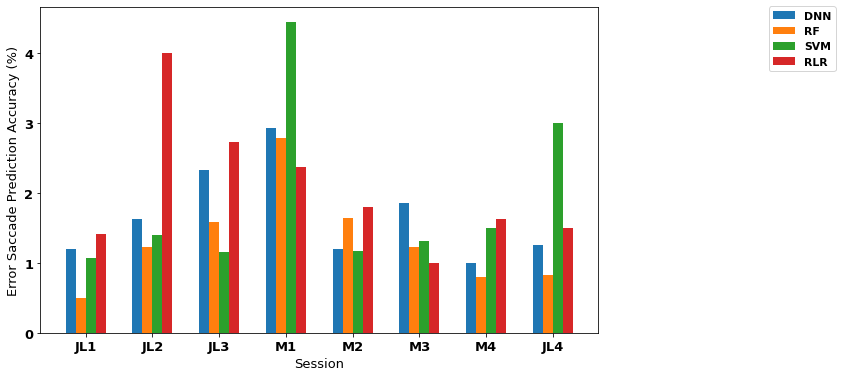

In [11]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

sessions = ['JL1', 'JL2', 'JL3', 'M1', 'M2', 'M3', 'M4', 'JL4']
x = np.arange(0, 2*len(sessions), 2)  # the label locations
width = 0.3
acc_dnn = np.array([68.57142857, 35.13513514, 48.27586207, 58.57142857, 28.57142857, 33.33333333, 27.77777778, 34.48275862])
acc_svm = np.array([45.71428571, 37.83783784, 50, 57.14285714, 47.61904762, 43.58974359, 25,20.68965517])
acc_rlr = np.array([48.57142857,32.43243243, 51.72413793, 54.28571429, 42.85714286, 25.64102564, 36.11111111, 20.68965517])
acc_rf = np.array([37.14285714, 29.72972973, 51.72413793, 55.71428571, 42.85714286, 41.02564103, 11.11111111, 17.24137931])

chance_dnn = np.array([57.14285714, 21.62162162, 20.68965517, 20.,23.80952381,17.94871795, 27.77777778, 27.5862069 ])
chance_svm = np.array([42.85714286, 27.02702703, 43.10344828, 12.85714286, 40.47619048, 33.33333333, 16.66666667,  6.89655172])
chance_rlr = np.array([34.28571429,  8.10810811, 18.96551724, 22.85714286, 23.80952381, 25.64102564, 22.22222222, 13.79310345])
chance_rf = np.array([74.28571429, 24.32432432, 32.75862069, 20.,26.19047619, 33.33333333, 13.88888889, 20.68965517])

acc_dnn = acc_dnn / chance_dnn
acc_svm = acc_svm / chance_svm
acc_rlr = acc_rlr / chance_rlr
acc_rf = acc_rf / chance_rf

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - 3*width/2, acc_dnn, width, label='DNN')
rects2 = ax.bar(x - width/2, acc_rf, width, label='RF')
rects4 = ax.bar(x + width/2, acc_svm, width, label='SVM')
rects3 = ax.bar(x + 3*width/2, acc_rlr, width, label='RLR')
# plt.errorbar(x - 3*width/2, acc_dnn, yerr=err_dnn, fmt='.', markersize='10', capsize=5, color='black')
# plt.errorbar(x - width/2, acc_rf, yerr=err_rf, fmt='.', markersize='10', capsize=5, color='black')
# plt.errorbar(x + width/2, acc_svm, yerr=err_svm, fmt='.', markersize='10', capsize=5, color='black')
# plt.errorbar(x + 3*width/2, acc_rlr, yerr=err_rlr, fmt='.', markersize='10', capsize=5, color='black')

# ax.set_ylim([0, 95])
ax.set_ylabel('Error Saccade Prediction Accuracy (%)')
ax.set_xlabel('Session')
ax.set_xticks(x)
ax.set_xticklabels(sessions)
ax.legend(loc='lower right', bbox_to_anchor=(1.435, .785), fontsize='small')
# fig.savefig("rule_performance.svg")

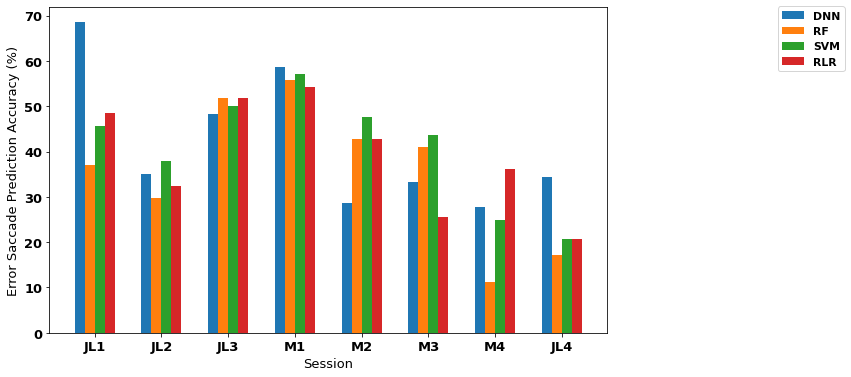

In [14]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

sessions = ['JL1', 'JL2', 'JL3', 'M1', 'M2', 'M3', 'M4', 'JL4']
x = np.arange(0, 2*len(sessions), 2)  # the label locations
width = 0.3
# acc_dnn = np.array([60,50.45045045, 47.78761062, 48.05194805, 37.5,20, 26.38888889, 22.58064516])
# acc_svm = np.array([46.66666667, 56.75675676, 53.98230088, 39.61038961, 18.75,18.33333333, 18.05555556, 9.67741935])
# acc_rlr = np.array([56.66666667, 54.95495495, 53.98230088, 44.15584416, 18.75, 20., 33.33333333, 22.58064516])
# acc_rf = np.array([53.33333333, 51.35135135, 46.01769912, 35.71428571, 18.75,16.66666667, 18.05555556, 12.90322581])

# chance_dnn = np.array([43.33333333, 17.11711712, 20.3539823,  11.03896104, 18.75,        8.33333333, 27.77777778, 22.58064516])
# chance_svm = np.array([46.66666667,  8.10810811, 36.28318584,  5.19480519, 31.25,       11.66666667, 23.61111111,  3.22580645])
# chance_rlr = np.array([43.33333333, 18.91891892, 19.46902655, 14.93506494, 12.5,        20., 26.38888889, 22.58064516])
# chance_rf = np.array([50.,10.81081081, 36.28318584, 13.63636364, 31.25,13.33333333, 19.44444444,  3.22580645])


acc_dnn = np.array([68.57142857, 35.13513514, 48.27586207, 58.57142857, 28.57142857, 33.33333333, 27.77777778, 34.48275862])
acc_svm = np.array([45.71428571, 37.83783784, 50, 57.14285714, 47.61904762, 43.58974359, 25,20.68965517])
acc_rlr = np.array([48.57142857,32.43243243, 51.72413793, 54.28571429, 42.85714286, 25.64102564, 36.11111111, 20.68965517])
acc_rf = np.array([37.14285714, 29.72972973, 51.72413793, 55.71428571, 42.85714286, 41.02564103, 11.11111111, 17.24137931])

# chance_dnn2 = np.array([57.14285714, 21.62162162, 20.68965517, 20.,23.80952381,17.94871795, 27.77777778, 27.5862069 ])
# chance_svm2 = np.array([42.85714286, 27.02702703, 43.10344828, 12.85714286, 40.47619048, 33.33333333, 16.66666667,  6.89655172])
# chance_rlr2 = np.array([34.28571429,  8.10810811, 18.96551724, 22.85714286, 23.80952381, 25.64102564, 22.22222222, 13.79310345])
# chance_rf2 = np.array([74.28571429, 24.32432432, 32.75862069, 20.,26.19047619, 33.33333333, 13.88888889, 20.68965517])

# acc_dnn = (acc_dnn * chance_dnn2) / (chance_dnn * acc_dnn2)
# acc_svm = (acc_svm * chance_svm2) / (chance_svm * acc_svm2)
# acc_rlr = (acc_rlr * chance_rlr2) / (chance_rlr * acc_rlr2)
# acc_rf = (acc_rf * chance_rf2) / (chance_rf * acc_rf2)

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - 3*width/2, acc_dnn, width, label='DNN')
rects2 = ax.bar(x - width/2, acc_rf, width, label='RF')
rects4 = ax.bar(x + width/2, acc_svm, width, label='SVM')
rects3 = ax.bar(x + 3*width/2, acc_rlr, width, label='RLR')
# plt.errorbar(x - 3*width/2, acc_dnn, yerr=err_dnn, fmt='.', markersize='10', capsize=5, color='black')
# plt.errorbar(x - width/2, acc_rf, yerr=err_rf, fmt='.', markersize='10', capsize=5, color='black')
# plt.errorbar(x + width/2, acc_svm, yerr=err_svm, fmt='.', markersize='10', capsize=5, color='black')
# plt.errorbar(x + 3*width/2, acc_rlr, yerr=err_rlr, fmt='.', markersize='10', capsize=5, color='black')

# ax.set_ylim([0, 95])
ax.set_ylabel('Error Saccade Prediction Accuracy (%)')
ax.set_xlabel('Session')
ax.set_xticks(x)
ax.set_xticklabels(sessions)
ax.legend(loc='lower right', bbox_to_anchor=(1.435, .785), fontsize='small')
# fig.savefig("rule_performance.svg")

In [ ]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

sessions = ['JL1', 'JL2', 'JL3', 'M1', 'M2', 'M3', 'M4', 'JL4']
x = np.arange(0, 2*len(sessions), 2)  # the label locations
width = 0.3
acc_dnn = np.array([59.88, 82.14, 71.34, 73.2, 60.61, 44.88, 67, 55.45])
acc_svm = np.array([49.15, 66.95, 53.48, 59.2, 45.07, 33.07, 56.67, 44.55])
acc_rlr = np.array([51.98, 74.29, 57.94, 65.2, 57.75, 29.92, 66.67, 50.49])
acc_rf = np.array([48.59, 60.17, 60.45, 58.4, 44.37, 37.8, 66.67, 46.53])

err_dnn = np.array([1.11, 0.87, 0.82, 0.92, 1.36, 1.47, 2.74, 1.90])
err_svm = np.zeros(8)+1.7e-9
err_rlr = np.zeros(8)+1.7e-9
err_rf = np.zeros(8)+1.7e-9

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - 3*width/2, acc_dnn, width, label='DNN')
rects2 = ax.bar(x - width/2, acc_rf, width, label='RF')
rects4 = ax.bar(x + width/2, acc_svm, width, label='SVM')
rects3 = ax.bar(x + 3*width/2, acc_rlr, width, label='RLR')
plt.errorbar(x - 3*width/2, acc_dnn, yerr=err_dnn, fmt='.', markersize='10', capsize=5, color='black')
plt.errorbar(x - width/2, acc_rf, yerr=err_rf, fmt='.', markersize='10', capsize=5, color='black')
plt.errorbar(x + width/2, acc_svm, yerr=err_svm, fmt='.', markersize='10', capsize=5, color='black')
plt.errorbar(x + 3*width/2, acc_rlr, yerr=err_rlr, fmt='.', markersize='10', capsize=5, color='black')

ax.set_ylim([0, 95])
ax.set_ylabel('Rule Decoding Accuracy (%)')
ax.set_xlabel('Session')
ax.set_xticks(x)
ax.set_xticklabels(sessions)
ax.legend(loc='lower right', bbox_to_anchor=(1.435, .785), fontsize='small')
fig.savefig("rule_performance.svg")

In [ ]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

sessions = ['JL1', 'JL2', 'JL3', 'M1', 'M2', 'M3', 'M4', 'JL4']
x = np.arange(0, 2*len(sessions), 2)  # the label locations
width = 0.3
acc_dnn = np.array([59.88, 82.14, 71.34, 73.2, 60.61, 44.88, 67, 55.45])
acc_svm = np.array([49.15, 66.95, 53.48, 59.2, 45.07, 33.07, 56.67, 44.55])
acc_rlr = np.array([51.98, 74.29, 57.94, 65.2, 57.75, 29.92, 66.67, 50.49])
acc_rf = np.array([48.59, 60.17, 60.45, 58.4, 44.37, 37.8, 66.67, 46.53])

err_dnn = np.array([1.11, 0.87, 0.82, 0.92, 1.36, 1.47, 2.74, 1.90])
err_svm = np.zeros(8)+1.7e-9
err_rlr = np.zeros(8)+1.7e-9
err_rf = np.zeros(8)+1.7e-9

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - 3*width/2, acc_dnn, width, label='DNN')
rects2 = ax.bar(x - width/2, acc_rf, width, label='RF')
rects4 = ax.bar(x + width/2, acc_svm, width, label='SVM')
rects3 = ax.bar(x + 3*width/2, acc_rlr, width, label='RLR')
plt.errorbar(x - 3*width/2, acc_dnn, yerr=err_dnn, fmt='.', markersize='10', capsize=5, color='black')
plt.errorbar(x - width/2, acc_rf, yerr=err_rf, fmt='.', markersize='10', capsize=5, color='black')
plt.errorbar(x + width/2, acc_svm, yerr=err_svm, fmt='.', markersize='10', capsize=5, color='black')
plt.errorbar(x + 3*width/2, acc_rlr, yerr=err_rlr, fmt='.', markersize='10', capsize=5, color='black')

ax.set_ylim([0, 95])
ax.set_ylabel('Rule Decoding Accuracy (%)')
ax.set_xlabel('Session')
ax.set_xticks(x)
ax.set_xticklabels(sessions)
ax.legend(loc='lower right', bbox_to_anchor=(1.435, .785), fontsize='small')
fig.savefig("rule_performance.svg")